# Uncertainty analysis

- We need to define the plume extent
- Idea:
    - Constant background
    - All points with value above the background considered as a plume.
    - False positive: background pixels considered part of cluster
    - False negative: plume pixels not considered in the cluster
    - Different types of high-valued areas
- Experiment on varying sparsity:
    - Different densities in different axis
    - How would that affect the results
- Experiment on missing data points
    - Add more missing points, what happens?
    - Add areas of missing points? Perlin noise?!
    

### Imports

In [1]:
import numpy as np
import pandas as pd
import SCEA
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cmcrameri.cm as cmc
from matplotlib import colormaps
from tqdm import tqdm
import datetime
import os
import sys
from pathlib import Path
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
# Set the default colormap
plt.rcParams["image.cmap"] = "cmc.batlow"

In [3]:
# Register the custom colormap
# colormaps.register(cmc.batlow, name='batlow')

In [4]:
# Paths

current_directory = Path(Path.cwd())

parent_directory = current_directory.parent

outputs_path = parent_directory / "outputs"
plots_path = parent_directory / "plots"

### Functions

In [5]:
def classification_outcomes(clusters, labels, reutrn_counts=False):
    is_clustered = clusters > 0
    labels = labels.astype(bool)
    is_true_positive = np.logical_and(is_clustered, labels)
    is_false_positive = np.logical_and(is_clustered, np.logical_not(labels))
    is_true_negative = np.logical_and(
        np.logical_not(is_clustered), np.logical_not(labels)
    )
    is_false_negative = np.logical_and(np.logical_not(is_clustered), labels)
    if reutrn_counts:
        return (
            is_true_positive.sum(),
            is_false_positive.sum(),
            is_true_negative.sum(),
            is_false_negative.sum(),
        )
    return is_true_positive, is_false_positive, is_true_negative, is_false_negative

In [6]:
def calculate_metrics_for_multiclusters(
    clusters: np.ndarray,
    labels: np.ndarray,
    verbose: bool = False,
) -> tuple:
    """
    Returns the
        - F1 score in general
        - F1 score for each true cluster
        - Number of unique found clusters in each true cluster
        - How many found clusters are (partly) in a true cluster
        - How many are not
        - Average and median size of each true found cluster
        - Average and median size of each false found cluster
        - Precision in general
        - Recall in general
    """

    # Initialize a list to store the f1 scores for each true cluster
    f1_scores = []
    n_found_clusters_in_true_cluster = []
    unique_found_clusters = np.unique(clusters[clusters > 0])
    true_found_clusters = np.unique(clusters[(labels > 0) & (clusters > 0)])
    false_found_clusters = unique_found_clusters[
        ~np.isin(unique_found_clusters, true_found_clusters)
    ]

    # Iterate over each true cluster
    for true_label in np.unique(labels):
        if true_label == 0:
            continue  # Skip the background label

        found_clusters_in_true_cluster = np.unique(clusters[labels == true_label])
        # Skip the background label (label 0)
        found_clusters_in_true_cluster = found_clusters_in_true_cluster[
            found_clusters_in_true_cluster != 0
        ]

        n_found_clusters_in_true_cluster.append(found_clusters_in_true_cluster.shape[0])

        is_cluster = np.isin(clusters, found_clusters_in_true_cluster)

        tp, fp, tn, fn = classification_outcomes(
            clusters=is_cluster, labels=(labels == true_label), reutrn_counts=True
        )
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0
        f1_scores.append(f1)


    n_true_positive_clusters = true_found_clusters.shape[0]
    n_false_postive_clusters = false_found_clusters.shape[0]
    n_unique_found_clusters = unique_found_clusters.shape[0]
    n_false_negative_clusters = np.sum(np.array(f1_scores)==0)

    # F1 score for whole cluster -wise
    tp = n_true_positive_clusters
    fp = n_false_postive_clusters
    fn = n_false_negative_clusters
    f1_scores_whole_clusters = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0

    # Average and median size of each true found cluster
    true_found_clusters_sizes = [
        np.sum(clusters == true_found_cluster)
        for true_found_cluster in true_found_clusters
    ]
    mean_true_found_clusters_size = np.mean(true_found_clusters_sizes) if true_found_clusters_sizes else 0
    median_true_found_clusters_size = np.median(true_found_clusters_sizes) if true_found_clusters_sizes else 0

    # Average and median size of each false found cluster
    false_found_clusters_sizes = [
        np.sum(clusters == false_found_cluster)
        for false_found_cluster in false_found_clusters
    ]
    mean_false_found_clusters_size = np.mean(false_found_clusters_sizes) if false_found_clusters_sizes else 0
    median_false_found_clusters_size = np.median(false_found_clusters_sizes) if false_found_clusters_sizes else 0


    # F1 score, precision, and recall in general
    tp, fp, tn, fn = classification_outcomes(
        clusters > 0, labels > 0, reutrn_counts=True
    )
    f1_general = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0
    precision_general = tp / (tp + fp) if (tp + fp) else 0
    recall_general = tp / (tp + fn) if (tp + fn) else 0

    percentage_true_found_clusters = n_true_positive_clusters / n_unique_found_clusters if n_unique_found_clusters else 0

    if verbose:
        print(f"F1 score for whole data: {f1_general:.2f}")
        print(f"Precision for whole data: {precision_general:.2f}")
        print(f"Recall for whole data: {recall_general:.2f}")
        print(f"F1 score for each true cluster: {[f'{x:.2f}' for x in f1_scores]}")
        print(
            f"Number of unique found clusters in each true cluster: {n_found_clusters_in_true_cluster}"
        )
        print(f"Number of true found clusters: {n_true_positive_clusters}")
        print(f"Number of false found clusters: {n_false_postive_clusters}")
        print(f"Percentage of True found clusters: {percentage_true_found_clusters:.2%}")
        print(
            f"Size of each true found cluster. Avg: {mean_true_found_clusters_size:.2f}, Median: {median_true_found_clusters_size:.2f}"
        )
        print(
            f"Size of each false found cluster. Avg: {mean_false_found_clusters_size:.2f}, Median: {median_false_found_clusters_size:.2f}"
        )

    return (
        f1_general,
        precision_general,
        recall_general,
        f1_scores,
        n_found_clusters_in_true_cluster,
        n_true_positive_clusters,
        n_false_postive_clusters,
        n_false_negative_clusters,
        f1_scores_whole_clusters,
        mean_true_found_clusters_size,
        median_true_found_clusters_size,
        mean_false_found_clusters_size,
        median_false_found_clusters_size,
    )

In [90]:
def plot_clusters(points, values, clusters, labels, save_to=None, save_format="pdf", **kwargs):
    """
    Plots the points and clusters with customizable plotting parameters.

    Parameters:
    - points: array-like, shape (n_samples, 2)
        The coordinates of the points.
    - values: array-like, shape (n_samples,)
        The values associated with the points (for coloring).
    - clusters: array-like, shape (n_samples,)
        The cluster labels for the points.
    - kwargs: additional keyword arguments for customization.
    """
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    axs = axs.flatten()

    # Plot the original data
    scatter1 = axs[0].scatter(points[:, 0], points[:, 1], c=values, **kwargs)
    axs[0].set_title("Original Data")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_aspect("equal")
    # cbar1 = fig.colorbar(scatter1, ax=axs[0])
    # cbar1.set_label('Values')

    # Plot the clusters
    scatter2 = axs[1].scatter(points[:, 0], points[:, 1], c=values, **kwargs)
    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        if cluster == 0:
            continue
        cluster_points = points[clusters == cluster]
        axs[1].scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            label=f"Cluster {cluster}",
            **kwargs,
        )
    axs[1].set_title(f"Found {int(unique_clusters.max())} Clusters")
    axs[1].set_xlabel("X")
    # axs[1].set_ylabel("Y")
    axs[1].set_aspect("equal")
    # cbar2 = fig.colorbar(scatter2, ax=axs[1])
    # cbar2.set_label('Values')
    # axs[1].legend()
    # Create a colorbar with its own axis

    scatter1 = axs[2].scatter(points[:, 0], points[:, 1], c=values, **kwargs)
    axs[2].set_title("Original Data")
    axs[2].set_xlabel("X")
    # axs[2].set_ylabel("Y")
    axs[2].set_aspect("equal")

    is_true_positive, is_false_positive, is_true_negative, is_false_negative = (
        classification_outcomes(clusters, labels)
    )
    axs[2].scatter(
        points[is_true_positive, 0],
        points[is_true_positive, 1],
        c="g",
        label="True Positive",
        **kwargs,
    )
    axs[2].scatter(
        points[is_false_positive, 0],
        points[is_false_positive, 1],
        c="r",
        label="False Positive",
        **kwargs,
    )
    # axs[2].scatter(points[true_negative, 0], points[true_negative, 1], c='b', label='True Negative')
    axs[2].scatter(
        points[is_false_negative, 0],
        points[is_false_negative, 1],
        c="y",
        label="False Negative",
        **kwargs,
    )
    axs[2].legend()

    # Plot text box with metrics
    tp = is_true_positive.sum()
    fp = is_false_positive.sum()
    tn = is_true_negative.sum()
    fn = is_false_negative.sum()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    textstr = f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    axs[2].text(
        0.05,
        0.95,
        textstr,
        transform=axs[2].transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )

    cbar = fig.colorbar(
        scatter1, ax=axs, orientation="vertical", fraction=0.02, pad=0.04
    )

    # Save the figure
    if save_to:
        plt.savefig(save_to, bbox_inches="tight", transparent=True, format=save_format)

    plt.show()

In [8]:
def plot_clusters_imshow(points, values, clusters, labels, **kwargs):
    """
    Plots the points and clusters using imshow so that each (x, y, value) becomes one pixel.

    Subplots:
      1. Original Data only.
      2. Clusters overlay on top of the original image (only nonzero clusters, using a discrete colormap).
      3. Classification outcomes overlay on the original image.
         True Positive = green, False Positive = red, False Negative = yellow.
         A legend is provided for these outcomes.

    One common colorbar (referring to the original image values) is shown for all subplots.

    Parameters:
    - points: array-like, shape (n_samples, 2)
        Coordinates of the points.
    - values: array-like, shape (n_samples,)
        Values associated with the points (for coloring the original image).
    - clusters: array-like, shape (n_samples,)
        Cluster labels for the points (0-cluster is not plotted).
    - labels: array-like, shape (n_samples,)
        True labels used for computing classification outcomes.
    - kwargs: additional keyword arguments (not used in this imshow version)

    Note: Assumes that a function `classification_outcomes(clusters, labels)` exists
    that returns (is_true_positive, is_false_positive, is_true_negative, is_false_negative).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from matplotlib.patches import Patch

    # Determine grid dimensions from point coordinates.
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    width = len(unique_x)
    height = len(unique_y)
    
    # Create a mapping from coordinates to grid indices.
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize images (2D arrays) with NaN so that missing pixels remain blank.
    img_orig = np.full((height, width), np.nan)
    img_clusters = np.full((height, width), np.nan)
    img_class = np.full((height, width), np.nan)

    # Populate the image arrays.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        # Original image: assign the value.
        img_orig[row, col] = values[i]
        # Clusters: only assign if cluster is nonzero.
        if clusters[i] != 0:
            img_clusters[row, col] = clusters[i]

    # Compute classification outcomes.
    is_tp, is_fp, is_tn, is_fn = classification_outcomes(clusters, labels)

    # Populate classification outcomes image:
    # 1 = True Positive, 2 = False Positive, 3 = False Negative.
    # True Negatives are left as NaN.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        if is_tp[i]:
            img_class[row, col] = 1
        elif is_fp[i]:
            img_class[row, col] = 2
        elif is_fn[i]:
            img_class[row, col] = 3

    # Create figure and subplots.
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    # --- Subplot 1: Original Data only ---
    im0 = axs[0].imshow(img_orig, origin="lower")
    axs[0].set_title("Original Data")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")

    # --- Subplot 2: Clusters overlay ---
    # First, plot the original image.
    axs[1].imshow(img_orig, origin="lower", alpha=1)
    # Overlay clusters using a discrete colormap (e.g. 'tab10').
    axs[1].imshow(img_clusters, origin="lower", cmap="tab20", alpha=1)
    # Count clusters (ignoring 0).
    unique_clusters = np.unique(clusters[clusters != 0])
    cluster_count = int(unique_clusters.max()) if unique_clusters.size > 0 else 0
    axs[1].set_title(f"Clusters (Found {cluster_count})")
    axs[1].set_xlabel("X")

    # --- Subplot 3: Classification Outcomes overlay ---
    # First, plot the original image.
    axs[2].imshow(img_orig, origin="lower", alpha=1)
    # Define a discrete colormap for classification outcomes:
    # 1: True Positive (green), 2: False Positive (red), 3: False Negative (yellow)
    class_colors = ["green", "red", "orange"]
    cmap_class = ListedColormap(class_colors)
    norm_class = BoundaryNorm([0.5, 1.5, 2.5, 3.5], len(class_colors))
    axs[2].imshow(
        img_class, origin="lower", cmap=cmap_class, norm=norm_class, alpha=1
    )
    axs[2].set_title("Classification Outcomes")
    axs[2].set_xlabel("X")
    # Create a legend for the classification outcomes.
    legend_elements = [
        Patch(facecolor="green", edgecolor="black", label="True Positive"),
        Patch(facecolor="red", edgecolor="black", label="False Positive"),
        Patch(facecolor="orange", edgecolor="black", label="False Negative"),
    ]
    axs[2].legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

    # Optionally, compute metrics (ignoring true negatives) and add a text box in subplot 3.
    tp = is_tp.sum()
    fp = is_fp.sum()
    fn = is_fn.sum()
    total = tp + fp + fn
    accuracy = (tp) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    textstr = (
        f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\nF1 Score: {f1:.2f}"
    )
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    axs[2].text(
        1.03,
        0.75,
        textstr,
        transform=axs[2].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # --- Common Colorbar ---
    # Create one colorbar for the entire figure (using the original image from subplot 1).
    cbar = fig.colorbar(im0, ax=axs, orientation="vertical", fraction=0.02, pad=0.13)
    cbar.set_label("Original Image Values")

    plt.show()

In [9]:
def plot_clusters_imshow_2(points, values, values_noisy, clusters, labels, save_to, **kwargs):
    """
    Plots the points and clusters using imshow so that each (x, y, value) becomes one pixel.

    Subplots:
      1. Original Data only.
      2. Clusters overlay on top of the original image (only nonzero clusters, using a discrete colormap).
      3. Classification outcomes overlay on the original image.
         True Positive = green, False Positive = red, False Negative = yellow.
         A legend is provided for these outcomes.

    One common colorbar (referring to the original image values_noisy) is shown for all subplots.

    Parameters:
    - points: array-like, shape (n_samples, 2)
        Coordinates of the points.
    - values_noisy: array-like, shape (n_samples,)
        Values_noisy associated with the points (for coloring the original image).
    - clusters: array-like, shape (n_samples,)
        Cluster labels for the points (0-cluster is not plotted).
    - labels: array-like, shape (n_samples,)
        True labels used for computing classification outcomes.
    - kwargs: additional keyword arguments (not used in this imshow version)

    Note: Assumes that a function `classification_outcomes(clusters, labels)` exists
    that returns (is_true_positive, is_false_positive, is_true_negative, is_false_negative).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from matplotlib.patches import Patch

    vmin = kwargs.get("vmin", None)
    vmax = kwargs.get("vmax", None)


    # Determine grid dimensions from point coordinates.
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    width = len(unique_x)
    height = len(unique_y)
    
    # Create a mapping from coordinates to grid indices.
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize images (2D arrays) with NaN so that missing pixels remain blank.
    img_orig = np.full((height, width), np.nan)
    img_orig_noisy = np.full((height, width), np.nan)
    img_clusters = np.full((height, width), np.nan)
    img_class = np.full((height, width), np.nan)

    # Populate the image arrays.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        # Original image: assign the value.
        img_orig_noisy[row, col] = values_noisy[i]
        img_orig[row, col] = values[i]

        # Clusters: only assign if cluster is nonzero.
        if clusters[i] != 0:
            img_clusters[row, col] = clusters[i]

    # Compute classification outcomes.
    is_tp, is_fp, is_tn, is_fn = classification_outcomes(clusters, labels)

    # Populate classification outcomes image:
    # 1 = True Positive, 2 = False Positive, 3 = False Negative.
    # True Negatives are left as NaN.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        if is_tp[i]:
            img_class[row, col] = 1
        elif is_fp[i]:
            img_class[row, col] = 2
        elif is_fn[i]:
            img_class[row, col] = 3

    # Create figure and subplots.
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()

    # --- Subplot 1: Original Data only ---
    im0 = axs[0].imshow(img_orig, origin="lower", vmin=vmin, vmax=vmax)
    axs[0].set_title("Original Data")
    #axs[0].set_xlabel("X")
    #axs[0].set_ylabel("Y")
    axs[0].set_aspect("equal")
    axs[0].set_xticks([])

    im0 = axs[1].imshow(img_orig_noisy, origin="lower", vmin=vmin, vmax=vmax)
    axs[1].set_title("Data with $\sigma=5$ standard deviations of gaussian noise")
    #axs[1].set_xlabel("X")
    #axs[1].set_ylabel("Y")
    axs[1].set_aspect("equal")
    axs[1].set_xticks([])
    axs[1].set_yticks([])


    # --- Subplot 2: Clusters overlay ---
    # First, plot the original image.
    axs[2].imshow(img_orig_noisy, origin="lower", alpha=1, vmin=vmin, vmax=vmax)
    # Overlay clusters using a discrete colormap (e.g. 'tab10').
    axs[2].imshow(img_clusters, origin="lower", cmap="tab20", alpha=1)
    # Count clusters (ignoring 0).
    unique_clusters = np.unique(clusters[clusters != 0])
    cluster_count = int(unique_clusters.max()) if unique_clusters.size > 0 else 0
    axs[2].set_title(f"Found cluster with SCEA")
    #axs[2].set_xlabel("X")
    #axs[2].set_ylabel("Y")
    axs[2].set_aspect("equal")

    # --- Subplot 3: Classification Outcomes overlay ---
    # First, plot the original image.
    axs[3].imshow(img_orig_noisy, origin="lower", alpha=1, vmin=vmin, vmax=vmax)
    # Define a discrete colormap for classification outcomes:
    # 1: True Positive (green), 2: False Positive (red), 3: False Negative (yellow)
    class_colors = ["green", "red", "orange"]
    cmap_class = ListedColormap(class_colors)
    norm_class = BoundaryNorm([0.5, 1.5, 2.5, 3.5], len(class_colors))
    axs[3].imshow(
        img_class, origin="lower", cmap=cmap_class, norm=norm_class, alpha=1
    )
    axs[3].set_title("Point-wise classification outcomes")
    axs[3].set_yticks([])

    #axs[3].set_xlabel("X")
    # Create a legend for the classification outcomes.
    legend_elements = [
        Patch(facecolor="green", edgecolor="black", label="True Positive"),
        Patch(facecolor="red", edgecolor="black", label="False Positive"),
        Patch(facecolor="orange", edgecolor="black", label="False Negative"),
    ]
    axs[3].legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1))

    # Optionally, compute metrics (ignoring true negatives) and add a text box in subplot 3.
    tp = is_tp.sum()
    fp = is_fp.sum()
    fn = is_fn.sum()
    total = tp + fp + fn
    accuracy = (tp) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    textstr = (
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\nF1 Score: {f1:.2f}"
    )
    props = dict(boxstyle="round", facecolor="white", alpha=0.8)
    axs[3].text(
        0.03,
        0.97,
        textstr,
        transform=axs[3].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # --- Common Colorbar ---
    # Create one colorbar for the entire figure (using the original image from subplot 1).
    #cbar = fig.colorbar(im0, ax=axs, orientation="vertical", fraction=0.02, pad=0.13)
    #cbar.set_label("Original Image Values_noisy")


    if save_to:
        plt.savefig(save_to, bbox_inches="tight", transparent=True, format="pdf")


    plt.show()

<>:94: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid escape sequence '\s'
/var/folders/p6/59vbd6tj4ts7d0rh5n3n2ms4rrn7dd/T/ipykernel_97910/1458855269.py:94: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_title("Data with $\sigma=5$ standard deviations of gaussian noise")


In [95]:
def plot_clusters_multicluster(points, values, clusters, labels, save_to=None, save_format="png", **kwargs):
    """
    Plots the points and clusters using imshow so that each (x, y, value) becomes one pixel.

    Subplots:
      1. Original Data only.
      2. Clusters overlay on top of the original image (only nonzero clusters, using a discrete colormap).
      3. Classification outcomes overlay on the original image.
         True Positive = green, False Positive = red, False Negative = yellow.
         A legend is provided for these outcomes.

    One common colorbar (referring to the original image values) is shown for all subplots.

    Parameters:
    - points: array-like, shape (n_samples, 2)
        Coordinates of the points.
    - values: array-like, shape (n_samples,)
        Values associated with the points (for coloring the original image).
    - clusters: array-like, shape (n_samples,)
        Cluster labels for the points (0-cluster is not plotted).
    - labels: array-like, shape (n_samples,)
        True labels used for computing classification outcomes.
    - kwargs: additional keyword arguments (not used in this imshow version)

    Note: Assumes that a function `classification_outcomes(clusters, labels)` exists
    that returns (is_true_positive, is_false_positive, is_true_negative, is_false_negative).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from matplotlib.patches import Patch

    # Determine grid dimensions from point coordinates.
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    width = len(unique_x)
    height = len(unique_y)
    
    # Create a mapping from coordinates to grid indices.
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize images (2D arrays) with NaN so that missing pixels remain blank.
    img_orig = np.full((height, width), np.nan)
    img_clusters = np.full((height, width), np.nan)
    img_class = np.full((height, width), np.nan)

    # Populate the image arrays.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        # Original image: assign the value.
        img_orig[row, col] = values[i]
        # Clusters: only assign if cluster is nonzero.
        if clusters[i] != 0:
            img_clusters[row, col] = clusters[i]

    # Compute classification outcomes.
    is_tp, is_fp, is_tn, is_fn = classification_outcomes(clusters, labels)

    (
        f1_general,
        precision_general,
        recall_general,
        f1_scores,
        n_found_clusters_in_true_cluster,
        n_true_found_clusters,
        n_false_found_clusters,
        n_false_negative_clusters,
        f1_scores_whole_clusters,
        mean_true_found_clusters_size,
        median_true_found_clusters_size,
        mean_false_found_clusters_size,
        median_false_found_clusters_size,
    ) = calculate_metrics_for_multiclusters(clusters, labels, verbose=False)

    # Populate classification outcomes image:
    # 1 = True Positive, 2 = False Positive, 3 = False Negative.
    # True Negatives are left as NaN.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        if is_tp[i]:
            img_class[row, col] = 1
        elif is_fp[i]:
            img_class[row, col] = 2
        elif is_fn[i]:
            img_class[row, col] = 3

    # Create figure and subplots.
    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    # --- Subplot 1: Original Data only ---
    im0 = axs[0].imshow(img_orig, origin="lower")
    axs[0].set_title("Original Data")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")

    # --- Subplot 2: Clusters overlay ---
    
    # First, plot the original image.
    axs[1].imshow(img_orig, origin="lower")
    # Overlay clusters using a discrete colormap (e.g. 'tab10').
    axs[1].imshow(img_clusters, origin="lower", cmap="tab20")
    # Count clusters (ignoring 0).
    unique_clusters = np.unique(clusters[clusters != 0])
    cluster_count = int(unique_clusters.max()) if unique_clusters.size > 0 else 0
    axs[1].set_title(f"Clusters (Found {cluster_count})")
    axs[1].set_xlabel("X")
    

    
    # --- Subplot 3: Classification Outcomes overlay ---
    # First, plot the original image.
    axs[2].imshow(img_orig, origin="lower", alpha=0.8)
    # Define a discrete colormap for classification outcomes:
    # 1: True Positive (green), 2: False Positive (red), 3: False Negative (yellow)
    class_colors = ["green", "red", "orange"]
    cmap_class = ListedColormap(class_colors)
    norm_class = BoundaryNorm([0.5, 1.5, 2.5, 3.5], len(class_colors))
    axs[2].imshow(
        img_class, origin="lower", cmap=cmap_class, norm=norm_class, alpha=0.9
    )
    axs[2].set_title("Classification Outcomes")
    axs[2].set_xlabel("X")
    # Create a legend for the classification outcomes.
    legend_elements = [
        Patch(facecolor="green", edgecolor="black", label="True Positive"),
        Patch(facecolor="red", edgecolor="black", label="False Positive"),
        Patch(facecolor="orange", edgecolor="black", label="False Negative"),
    ]
    axs[2].legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1.03))

    # Optionally, compute metrics (ignoring true negatives) and add a text box in subplot 3.
    tp = is_tp.sum()
    fp = is_fp.sum()
    fn = is_fn.sum()
    total = tp + fp + fn
    accuracy = (tp) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    )
    textstr = (
        f"F1 for whole data pointwise: {f1_general:.2f}\n"
        f"Precision for whole data: {precision_general:.2f}\n"
        f"Recall for whole data: {recall_general:.2f}\n"
        f"N. clusters in true areas : {n_true_found_clusters}\n"
        f"N. clusters not in true areas: {n_false_found_clusters}\n"
        f"N. clusters not found: {n_false_negative_clusters}\n"
        f"F1 cluster-wise: {f1_scores_whole_clusters:.2f}\n"
        f"True cluster size: mean: {mean_true_found_clusters_size:.1f}, median: {median_true_found_clusters_size:.1f}\n"
        f"False cluster size: mean: {mean_false_found_clusters_size:.1f}, median: {median_false_found_clusters_size:.1f}"
    )
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    axs[2].text(
        1.03,
        0.78,
        textstr,
        transform=axs[2].transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

    #textstr2 = (
    #    f"F1 score for each true cluster: \n{[f'{x:.2f}' for x in f1_scores]}\n \n"
    #    f"Number of found clusters in each true cluster: \n {n_found_clusters_in_true_cluster}\n"
    #)

    """
    axs[2].text(
        .03,
        1.3,
        textstr2,
        transform=axs[2].transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )
    """

    # --- Common Colorbar ---
    # Create one colorbar for the entire figure (using the original image from subplot 1).
    cbar = fig.colorbar(im0, ax=axs, orientation="vertical", fraction=0.02, pad=0.2)
    cbar.set_label("Original Image Values")

    # Table 

    # Only 2 decimals for the F1 scores
    f1_scores_table = [f"{i+1}:\n {x:.2f}" for i, x in enumerate(f1_scores)]    
    f1_scores_table = np.flipud(np.array(f1_scores_table).reshape(4, 4).T)  
    axs[2].table(
        f1_scores_table,
        bbox=[1.02, 0, 0.5, 0.4],  # [x, y, width, height]
        cellLoc="center",
        colWidths=[0.1, 0.1, 0.1, 0.1],
    )
    
    # Add a custom title for the table
    axs[2].text(
        1.02, 0.41, "F1 Scores Table for each cluster", transform=axs[2].transAxes,
        fontsize=10, fontweight='bold', va='bottom'
    )

    if save_to:
        plt.savefig(save_to, bbox_inches="tight", transparent=True, format=save_format)
    
    plt.show()

In [ ]:
def plot_heatmap(
    scores_per_radius_func_s,
    noise_levels,
    radius_func_sigmas_thresholds,
    title="Heatmap of F1 Scores Across Different Noise Levels and Radius Function Sensitivity parameters",
    y_label="Radius_func_sigma -parameter\n(lower value -> more sensitive)",
    best_param_box_size=90,
    save_to=None,
):
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))

    scores_per_radius_func_s = np.array(scores_per_radius_func_s)
    cax = ax.matshow(scores_per_radius_func_s, vmin=0, vmax=1)
    cbar = fig.colorbar(cax)
    cbar.set_label("Average F1 score")

    # Set ticks for every point
    xticks = np.arange(len(noise_levels))
    yticks = np.arange(len(radius_func_sigmas_thresholds))

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Set labels for every other tick
    ax.set_xticklabels(
        [
            str(label) if i % 2 == 0 else ""
            for i, label in enumerate(noise_levels.round(4))
        ]
    )
    ax.set_yticklabels(
        [
            str(label) if i % 1 == 0 else ""
            for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
        ]
    )

    # Lower the font size of the tick labels and rotate them
    ax.tick_params(axis="both", which="major", labelsize=9)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    # Put the median scores for each parameter in the second y axis labels on the right of the heatmap
    # median_scores_per_parameter = scores_per_radius_func_s.median(axis=1)
    median_scores_per_parameter = np.median(scores_per_radius_func_s, axis=1)
    # Add text annotations for median scores
    max_median_score = median_scores_per_parameter.max()
    for i, median_score in enumerate(median_scores_per_parameter):
        if median_score == max_median_score:
            ax.text(
                len(noise_levels),
                i,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=9,
                fontweight="bold",
            )
        else:
            ax.text(
                len(noise_levels),
                i,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=9,
            )
    # Add a title on the right for the median values
    ax.text(
        len(noise_levels) + 3.1,
        len(radius_func_sigmas_thresholds) / 2,
        "Median scores for each row",
        va="center",
        rotation=90,
        ha="left",
        fontsize=12,
    )
    ax.scatter(
        np.arange(len(scores_per_radius_func_s[0])),
        np.argmax(scores_per_radius_func_s, axis=0),
        marker="s",
        linewidths=0.6,
        edgecolor="black",
        alpha=0.8,
        s=best_param_box_size,
        facecolor="none",
        label=f"Best parameter in each noise level",
    )
    ax.legend(loc="lower right", fontsize=9)
    ax.set_xlabel("Noise level (standard deviation of Gaussian noise)")
    ax.set_ylabel(y_label)
    """
    ax.text(
        - 4.4,
        len(radius_func_sigmas_thresholds) / 2,
        f"(Lower value $\\rightarrow$ more sensitive $\\rightarrow$ bigger cluster)",
        va="center",
        rotation=90,
        ha="left",
        fontsize=7,
    )
    """
    # ax.set_ylabel("Radius_func_sigma -parameter\n$\\small{(lower\\ value\\ \\rightarrow\\ more\\ sensitive)}$")
    ax.set_title(title)



    plt.show()

## Data - single cluster

### Polynomial plume

In [12]:
# Define the data
meshgrid = np.meshgrid(np.linspace(-30, 30, 80), np.linspace(-30, 30, 80))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
values = -0.01 * x**4 + 1.3 * x**2 + 12 * x + 100 - 6 * y**2 + 80
values[values < 0] = 0
is_positive = values > 0


points_polynomial = np.array([x, y]).T
x_polynomial = x
y_polynomial = y
values_polynomial = values
labels_polynomial = is_positive

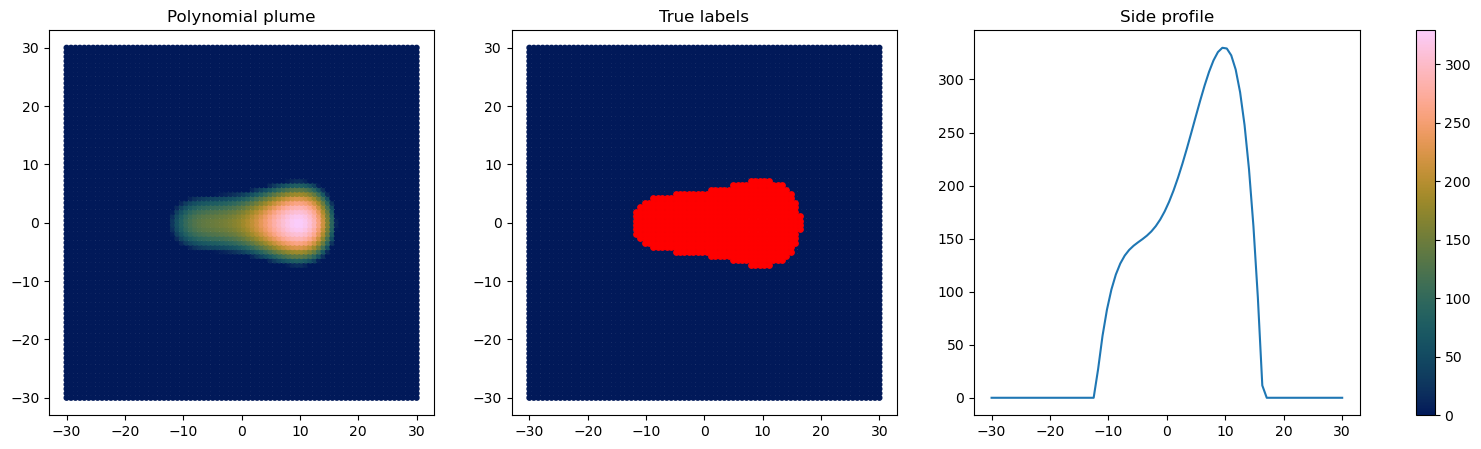

In [13]:
# Single plume figure


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Polynomial plume")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[is_positive], y[is_positive], s=15, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

# Side profile
x = np.linspace(-30, 30, 80)
values = -0.01 * x**4 + 1.3 * x**2 + 12 * x + 100 + 80
values[values < 0] = 0
axs[2].plot(x, values)
axs[2].set_title("Side profile")

plt.show()

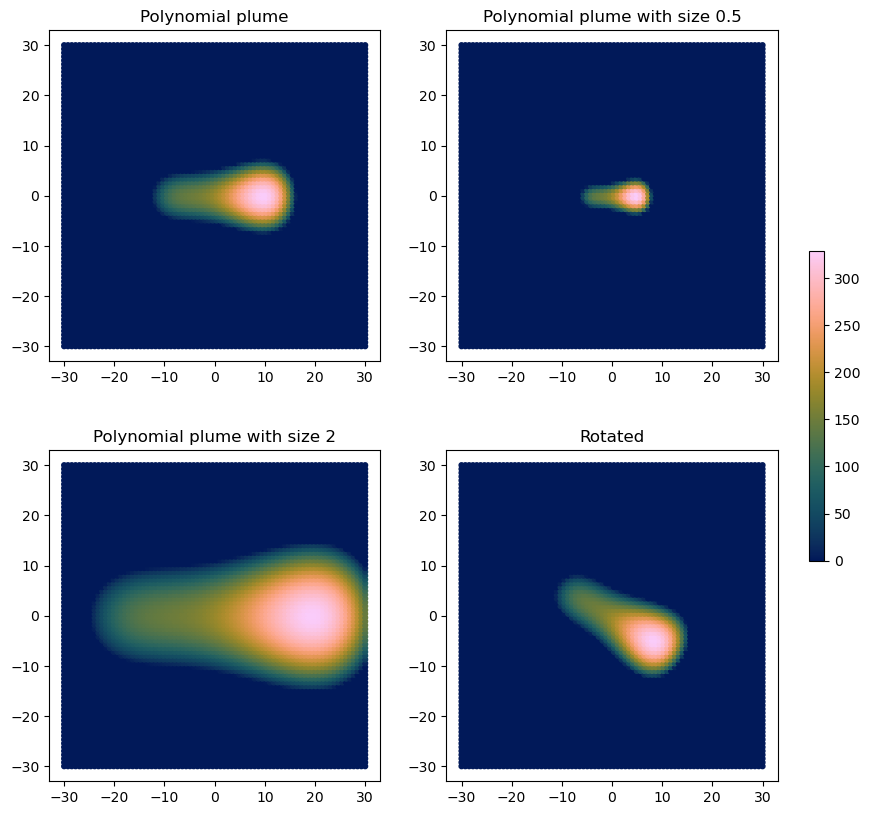

In [14]:
# Different sizes and rotations


fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# Define the data
meshgrid = np.meshgrid(np.linspace(-30, 30, 80), np.linspace(-30, 30, 80))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
size = 1
values = (
    -0.01 * (x * 1 / size) ** 4
    + 1.3 * (x * 1 / size) ** 2
    + 12 * (x * 1 / size)
    + 100
    - 6 * (y * 1 / size) ** 2
    + 80
)
values[values < 0] = 0

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Polynomial plume")
axs[0].set_aspect("equal")


# 2nd plot
size = 0.5
values = (
    -0.01 * (x * 1 / size) ** 4
    + 1.3 * (x * 1 / size) ** 2
    + 12 * (x * 1 / size)
    + 100
    - 6 * (y * 1 / size) ** 2
    + 80
)
values[values < 0] = 0
axs[1].scatter(x, y, c=values, s=12)
axs[1].set_title(f"Polynomial plume with size {size}")
axs[1].set_aspect("equal")


# 3rd plot
size = 2
values = (
    -0.01 * (x * 1 / size) ** 4
    + 1.3 * (x * 1 / size) ** 2
    + 12 * (x * 1 / size)
    + 100
    - 6 * (y * 1 / size) ** 2
    + 80
)
values[values < 0] = 0
axs[2].scatter(x, y, c=values, s=12)
axs[2].set_title(f"Polynomial plume with size {size}")
axs[2].set_aspect("equal")

# 4th plot
size = 1
theta = np.pi / 6
# x′=xcosθ−ysinθ
# y′=xsin⁡θ+ycos⁡θ
values = (
    -0.01 * ((x * np.cos(theta) - y * np.sin(theta)) * 1 / size) ** 4
    + 1.3 * ((x * np.cos(theta) - y * np.sin(theta)) * 1 / size) ** 2
    + 12 * ((x * np.cos(theta) - y * np.sin(theta)) * 1 / size)
    + 100
    - 6 * ((x * np.sin(theta) + y * np.cos(theta)) * 1 / size) ** 2
    + 80
)
values[values < 0] = 0
axs[3].scatter(x, y, c=values, s=12)
axs[3].set_title(f"Rotated")
axs[3].set_aspect("equal")


# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

### Linear

In [15]:
# Define the data
linear_function = lambda x, y: np.maximum(-abs(x) * 4 - abs(y) * 4 + 16, 1)

meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
values = linear_function(x, y)

points_linear = np.array([x, y]).T
x_linear = x
y_linear = y
meshgrid_linear = meshgrid
values_linear = values
is_true_label = values > 1
labels_linear = is_true_label

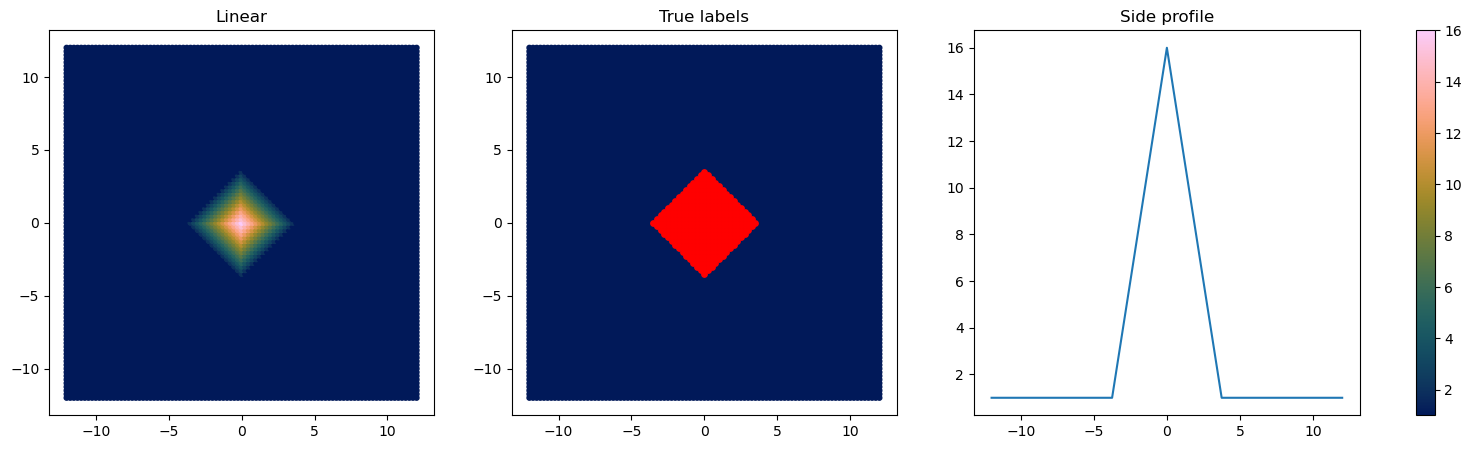

In [16]:
# Single cluster figure

x = x_linear
y = y_linear
values = values_linear
labels = labels_linear
meshgrid = meshgrid_linear


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Linear")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=15, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")


# 3rd plot
x_when_y_is_zero = meshgrid[0][np.where(meshgrid[1] == 0)].flatten()
values_when_y_is_zero = linear_function(x_when_y_is_zero, 0)
axs[2].plot(x_when_y_is_zero, values_when_y_is_zero)
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

### Linear polar

In [17]:
# Define the polar linear data
# Define the function in polar coordinates

linear_function_polar = lambda r: np.maximum(-r * 4 + 16, 1)

meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = linear_function_polar(R)


points_linear_polar = np.array([x, y]).T
x_linear_polar = x
y_linear_polar = y
meshgrid_linear_polar = meshgrid
values_linear_polar = values
labels_linear_polar = values > 1

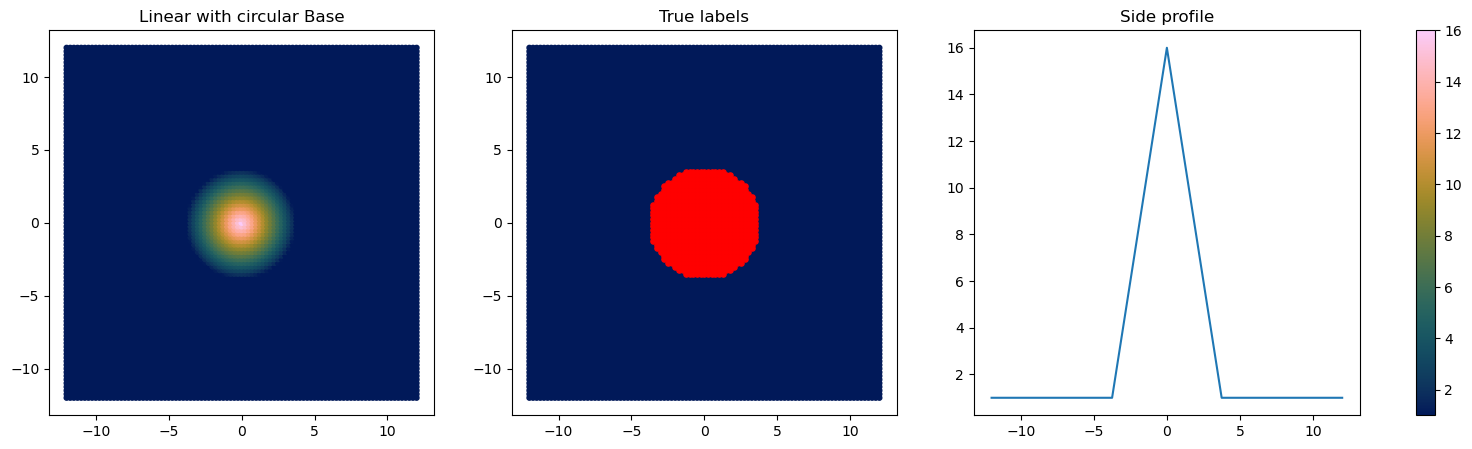

In [18]:
# With polar coordinates, so that the base is circular

x = x_linear_polar
y = y_linear_polar
values = values_linear_polar
labels = labels_linear_polar


# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

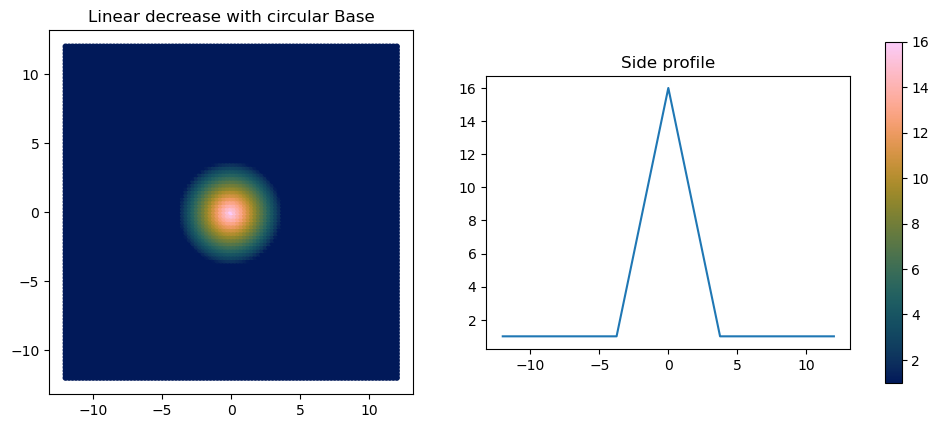

In [19]:
# With polar coordinates, so that the base is circular

x = x_linear_polar
y = y_linear_polar
values = values_linear_polar
labels = labels_linear_polar


# Plot the function
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear decrease with circular Base")
axs[0].set_aspect("equal")

## 2nd plot
#axs[1].scatter(x, y, c=values, s=12)
#axs[1].scatter(x[labels], y[labels], s=14, c="r")
#axs[1].set_title("True labels")
#axs[1].set_aspect("equal")

# 3rd plot
axs[1].plot(x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]))
axs[1].set_aspect(1.2)
axs[1].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

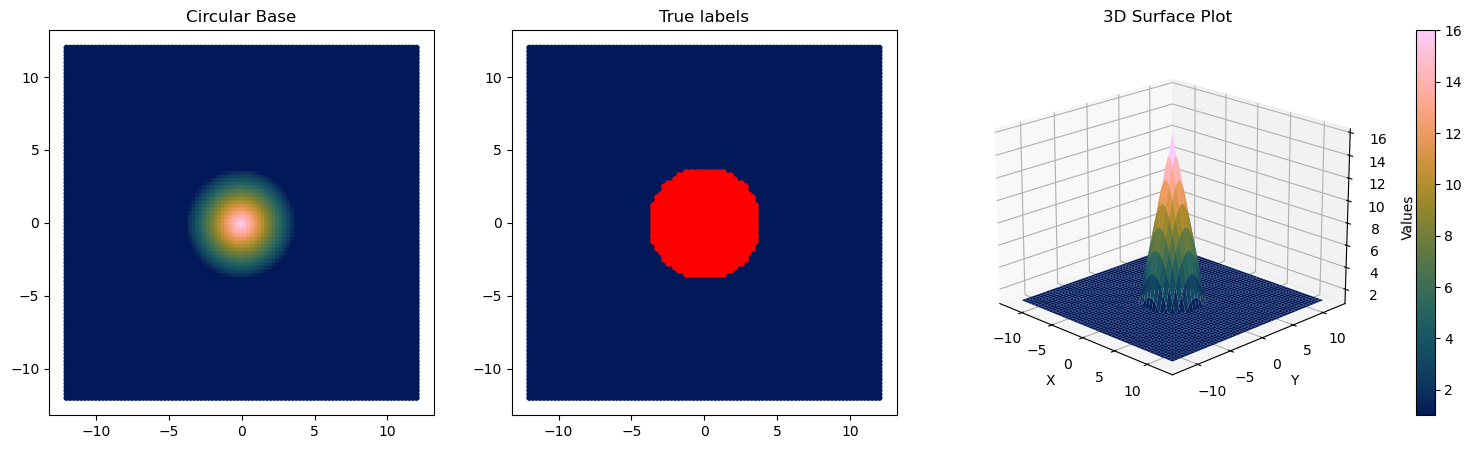

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define the function in polar coordinates
def linear_function_polar(r):
    return np.maximum(16 - r * 4, 1)


# Create a grid of points in Cartesian coordinates
meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
X = meshgrid[0]
Y = meshgrid[1]


# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(X**2 + Y**2)  # How far the grid point is from the origin

# Evaluate the function in polar coordinates
values = linear_function_polar(R)

# Plot the function
fig = plt.figure(figsize=(18, 5))

# 1st plot
ax1 = fig.add_subplot(131)
sc = ax1.scatter(X.flatten(), Y.flatten(), c=values.flatten(), s=12)
ax1.set_title("Circular Base")
ax1.set_aspect("equal")

# 2nd plot
ax2 = fig.add_subplot(132)
is_positive = values > 1
ax2.scatter(X.flatten(), Y.flatten(), c=values.flatten(), s=12)
ax2.scatter(
    X.flatten()[is_positive.flatten()], Y.flatten()[is_positive.flatten()], s=14, c="r"
)
ax2.set_title("True labels")
ax2.set_aspect("equal")

# 3rd plot
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot_surface(X, Y, values, cmap="cmc.batlow")
ax3.set_title("3D Surface Plot")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Values")
ax3.view_init(elev=20, azim=-45)  # Adjust the elevation and azimuthal angles as needed

# Create a colorbar with its own axis
cbar = fig.colorbar(
    sc, ax=[ax1, ax2, ax3], orientation="vertical", fraction=0.02, pad=0.04
)

plt.show()

### Exponential

In [21]:
exponential_decrease_continuous = lambda x: np.min(
    [2 ** (-x + 2), 2 ** (+x + 2)], axis=0
)
exponential_decrease = lambda x, y: np.maximum(
    exponential_decrease_continuous(x) * exponential_decrease_continuous(y), 1
)

meshgrid_exponential = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x_exponential = meshgrid_exponential[0].flatten()
y_exponential = meshgrid_exponential[1].flatten()
values_exponential = exponential_decrease(x_exponential, y_exponential)
labels_exponential = values_exponential > 1

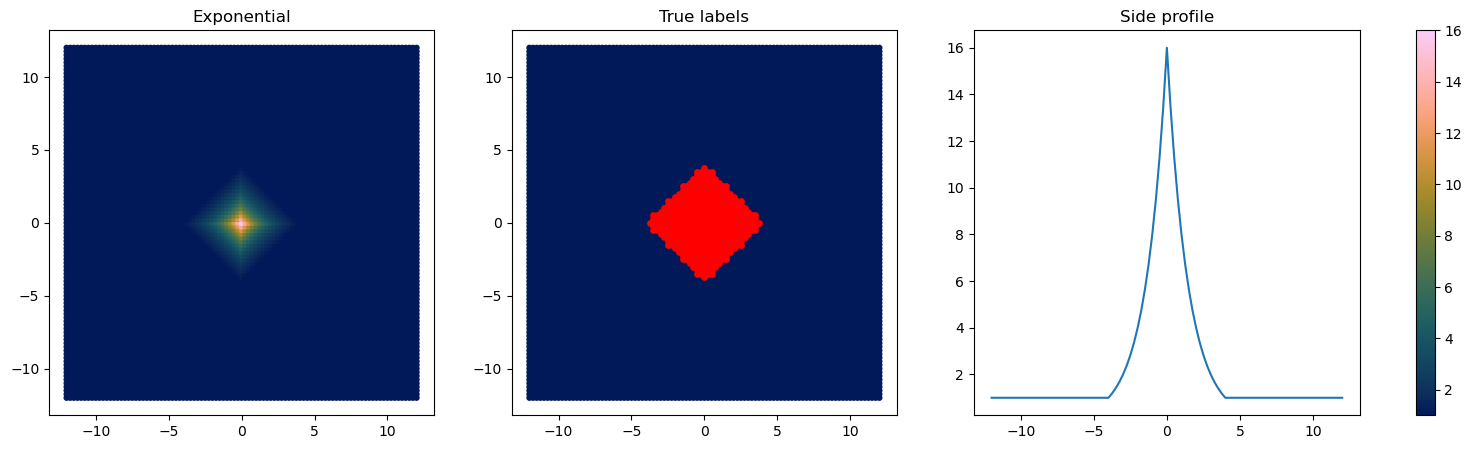

In [22]:
# Define the data
x = x_exponential
y = y_exponential
values = values_exponential
labels = labels_exponential
meshgrid = meshgrid_exponential

# Single plume figure


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Exponential")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=15, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")


# 3rd plot
axs[2].plot(x[np.where(y == 0)], exponential_decrease(x[np.where(y == 0)], 0))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

### Exponential polar

In [23]:
# Define the data

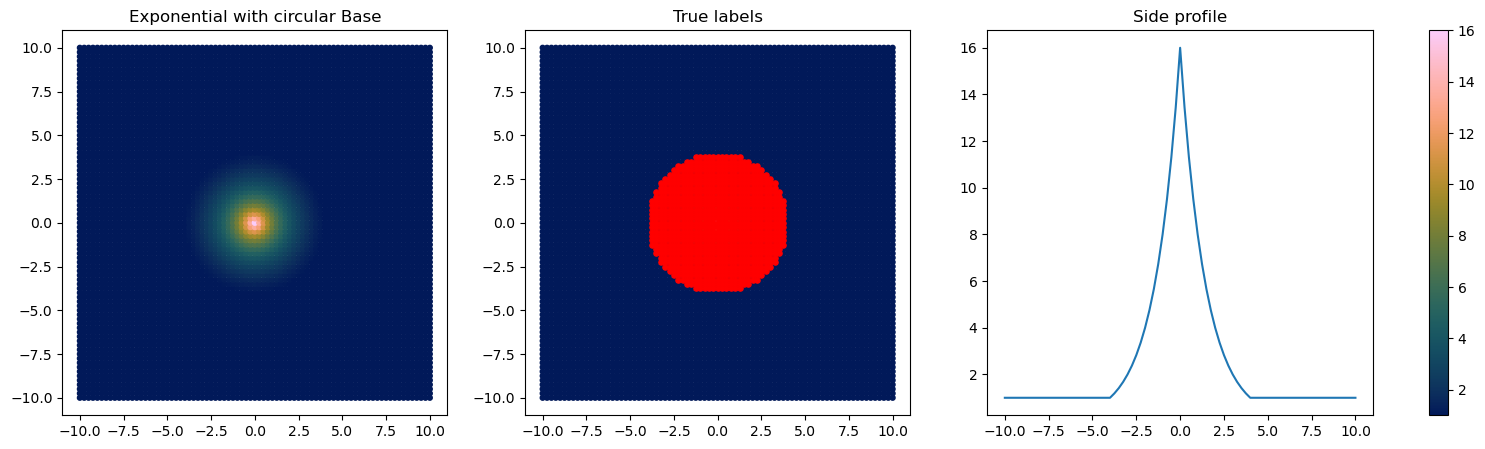

In [24]:
# Define the polar exponential data
exponential_decrease_continuous = lambda x: np.min(
    [2 ** (-x + 2), 2 ** (+x + 2)], axis=0
)
exponential_decrease = lambda x, y: np.maximum(
    exponential_decrease_continuous(x) * exponential_decrease_continuous(y), 1
)

exponential_function_polar = lambda r: np.maximum(
    exponential_decrease_continuous(r) * exponential_decrease_continuous(0), 1
)

meshgrid = np.meshgrid(np.linspace(-10, 10, 81), np.linspace(-10, 10, 81))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = exponential_function_polar(R)

points_exponential_polar = np.array([x, y]).T
x_exponential_polar = x
y_exponential_polar = y
meshgrid_exponential_polar = meshgrid
values_exponential_polar = values
labels_exponential_polar = values > 1

# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Exponential with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels_exponential_polar], y[labels_exponential_polar], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], exponential_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

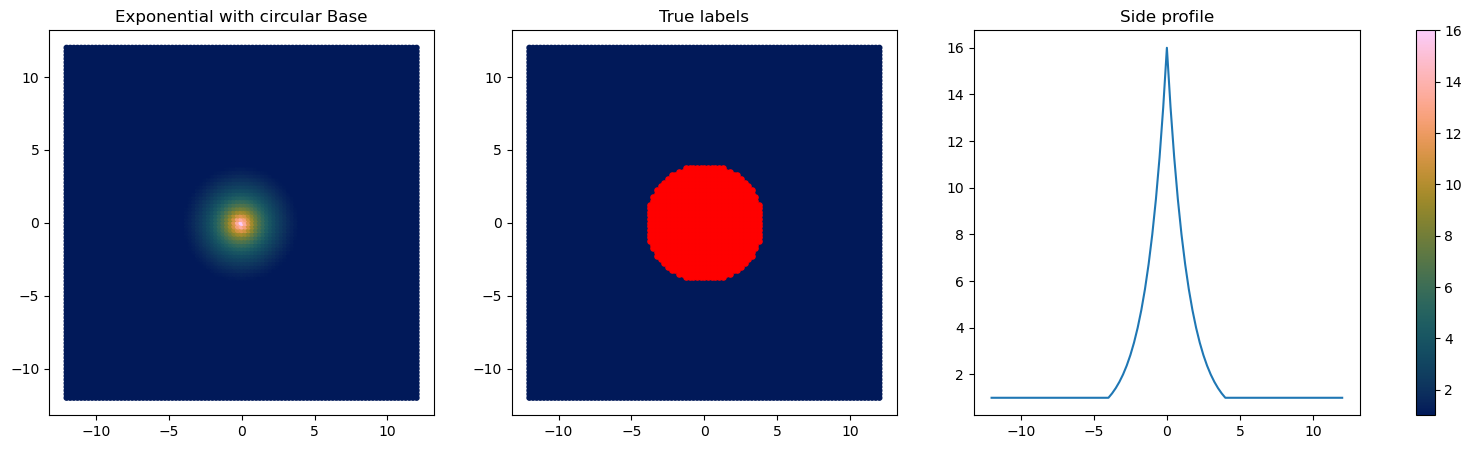

In [25]:
# Version 2


# Define the polar exponential data
exponential_decrease_continuous = lambda x: np.min(
    [2 ** (-x + 2), 2 ** (+x + 2)], axis=0
)
exponential_decrease = lambda x, y: np.maximum(
    exponential_decrease_continuous(x) * exponential_decrease_continuous(y), 1
)

exponential_function_polar = lambda r: np.maximum(2 ** (-r + 4), 1)

meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = exponential_function_polar(R)

points_exponential_polar = np.array([x, y]).T
x_exponential_polar = x
y_exponential_polar = y
meshgrid_exponential_polar = meshgrid
values_exponential_polar = values
labels_exponential_polar = values > 1

# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Exponential with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels_exponential_polar], y[labels_exponential_polar], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], exponential_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

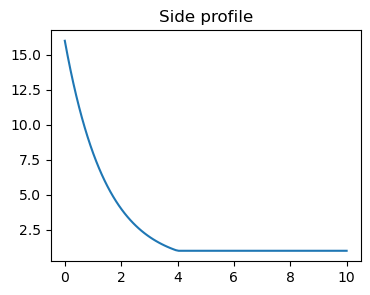

In [26]:
r = np.linspace(0, 10, 100)
values = np.maximum(2 ** (-r + 4), 1)

plt.figure(figsize=(4, 3))
plt.plot(r, values)
plt.title("Side profile")
plt.show()

### Linear vs exponential

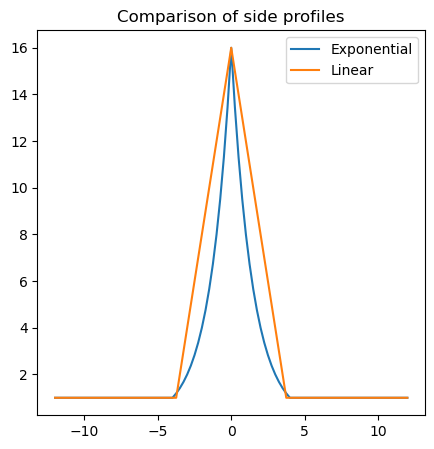

In [27]:
# Comparison of side profiles

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

x = x_exponential
y = y_exponential
R = np.sqrt(x**2 + y**2)
axs.plot(
    x[np.where(y == 0)],
    exponential_function_polar(R[np.where(y == 0)]),
    label="Exponential",
)

x = x_linear_polar
y = y_linear_polar
R = np.sqrt(x**2 + y**2)
axs.plot(
    x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]), label="Linear"
)
axs.legend()
plt.title("Comparison of side profiles")
plt.show()

### Gaussian

### Advection–diffusion equation plume 

In [28]:
def simulate_plume(
    num_steps=300,
    plume_intensity=1.0,  # strength of the source (per time unit)
    wind_speed=1.0,  # wind speed (grid units per time unit)
    wind_direction=45,  # wind direction in degrees (0 = east, 90 = north)
    diffusion_coefficient=0.2,  # dispersion/diffusion rate
    source_location=(50, 10),  # (i, j) index of the source in the grid
    grid_size=(100, 100),  # grid dimensions (nx, ny)
    dx=1.0,
    dy=1.0,  # grid spacing in x and y
    dt=0.1,  # time step size
    plot_every_n_steps=200,
):  # plot every n-th time step

    nx, ny = grid_size
    # Initialize concentration field to zero
    C = np.zeros((nx, ny))

    # Convert wind direction from degrees to radians.
    # (Here, 0° means wind blowing to the right (east) and 90° upward (north))
    rad = np.deg2rad(wind_direction)
    u = wind_speed * np.cos(rad)  # x-component of wind
    v = wind_speed * np.sin(rad)  # y-component of wind

    # Set up the plot
    plt.figure(figsize=(6, 5))

    for step in range(1, num_steps + 1):
        # Inject the plume continuously at the source location.
        i_src, j_src = source_location
        C[i_src, j_src] += plume_intensity * dt

        # Create a new concentration array for the next time step.
        C_new = np.copy(C)

        # --- Compute updates on interior grid points ---
        # We update only the interior points (excluding boundaries).
        # For the advection terms, we use an upwind scheme:
        if u >= 0:
            dC_dx = (C[1:-1, 1:-1] - C[:-2, 1:-1]) / dx
        else:
            dC_dx = (C[2:, 1:-1] - C[1:-1, 1:-1]) / dx

        if v >= 0:
            dC_dy = (C[1:-1, 1:-1] - C[1:-1, :-2]) / dy
        else:
            dC_dy = (C[1:-1, 2:] - C[1:-1, 1:-1]) / dy

        # Diffusion (central differences)
        d2C_dx2 = (C[2:, 1:-1] - 2 * C[1:-1, 1:-1] + C[:-2, 1:-1]) / dx**2
        d2C_dy2 = (C[1:-1, 2:] - 2 * C[1:-1, 1:-1] + C[1:-1, :-2]) / dy**2

        # Update interior points with the advection-diffusion equation:
        #   ∂C/∂t + u ∂C/∂x + v ∂C/∂y = D (∂²C/∂x² + ∂²C/∂y²)
        C_new[1:-1, 1:-1] = C[1:-1, 1:-1] + dt * (
            -u * dC_dx - v * dC_dy + diffusion_coefficient * (d2C_dx2 + d2C_dy2)
        )

        # --- Apply boundary conditions (here: no-flux boundaries) ---
        # This simply copies the values from the nearest interior cell.
        C_new[0, :] = C_new[1, :]
        C_new[-1, :] = C_new[-2, :]
        C_new[:, 0] = C_new[:, 1]
        C_new[:, -1] = C_new[:, -2]

        # Update concentration field for next iteration.
        C = C_new

        # Plot every few time steps.

        if step % plot_every_n_steps == 0:
            plt.figure(figsize=(3.5, 3.5))
            plt.clf()
            plt.imshow(C.T, origin="lower", extent=[0, nx * dx, 0, ny * dy])
            plt.title(f"Time step: {step}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.colorbar(label="Concentration")
            plt.pause(0.05)

    plt.show()

    return C

<Figure size 600x500 with 0 Axes>

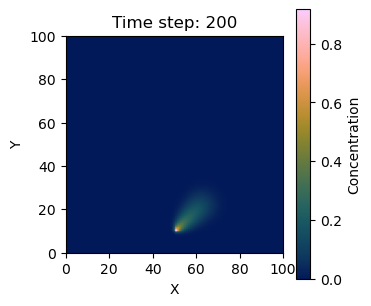

In [29]:
C = simulate_plume(
    num_steps=200,
    plume_intensity=2.0,  # strength of the source (per time unit)
    wind_speed=1.0,  # wind speed (grid units per time unit)
    wind_direction=45,  # wind direction in degrees (0 = east, 90 = north)
    diffusion_coefficient=0.2,  # dispersion/diffusion rate
    plot_every_n_steps=200,
)

<Figure size 600x500 with 0 Axes>

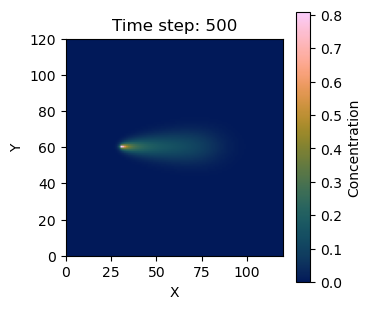

In [30]:
C = simulate_plume(
    num_steps=500,
    plume_intensity=2.0,  # strength of the source (per time unit)
    wind_speed=1,  # wind speed (grid units per time unit)
    wind_direction=0,  # wind direction in degrees (0 = east, 90 = north)
    diffusion_coefficient=0.5,  # dispersion/diffusion rate
    source_location=(30, 60),  # (i, j) index of the source in the grid
    grid_size=(120, 120),  # grid dimensions (nx, ny)
    dx=1.0,
    dy=1.0,  # grid spacing in x and y
    dt=0.1,  # time step size
    plot_every_n_steps=500,
)  # plot every n-th time step

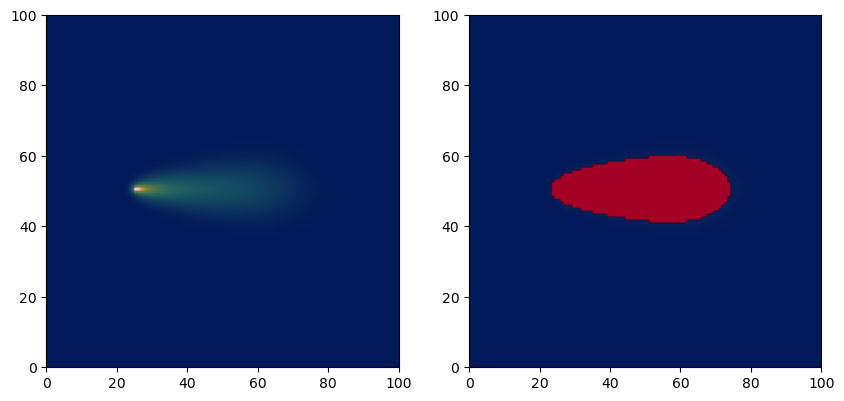

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(C.T, origin="lower", extent=[0, 100, 0, 100])

# Create a masked array where zero values are masked
masked_C = np.ma.masked_where(C.T <= 0.02, np.ones_like(C.T))

# Plot the original data
axs[1].imshow(C.T, origin="lower", extent=[0, 100, 0, 100])
# Overlay the masked array with transparency for zero values
axs[1].imshow(masked_C, origin="lower", extent=[0, 100, 0, 100], alpha=1, cmap="RdYlBu")

plt.show()

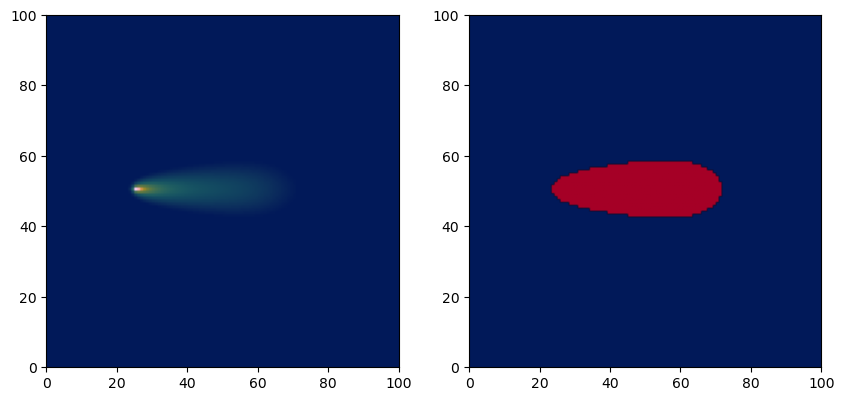

In [32]:
C[C < 0.03] = 0.03

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(C.T, origin="lower", extent=[0, 100, 0, 100])

# Create a masked array where zero values are masked
masked_C = np.ma.masked_where(C.T <= 0.03, np.ones_like(C.T))

# Plot the original data
axs[1].imshow(C.T, origin="lower", extent=[0, 100, 0, 100])
# Overlay the masked array with transparency for zero values
axs[1].imshow(masked_C, origin="lower", extent=[0, 100, 0, 100], alpha=1, cmap="RdYlBu")

plt.show()

In [33]:
C.max()

np.float64(0.8072513461643923)

In [34]:
# Sample image matrix
image_matrix = C

# Get the coordinates and values
coordinates = []
for x in range(image_matrix.shape[0]):
    for y in range(image_matrix.shape[1]):
        value = image_matrix[x, y]
        if value != 0:
            coordinates.append((x, y, value))

# Print the coordinates and values
# for coord in coordinates:
#    print(f"x: {coord[0]}, y: {coord[1]}, value: {coord[2]}")

In [35]:
coordinates = np.array(coordinates)
x_advection = coordinates[:, 0]
y_advection = coordinates[:, 1]
points_advection = np.array([x_advection, y_advection]).T
values_advection = coordinates[:, 2]
labels_advection = values_advection > 0.03

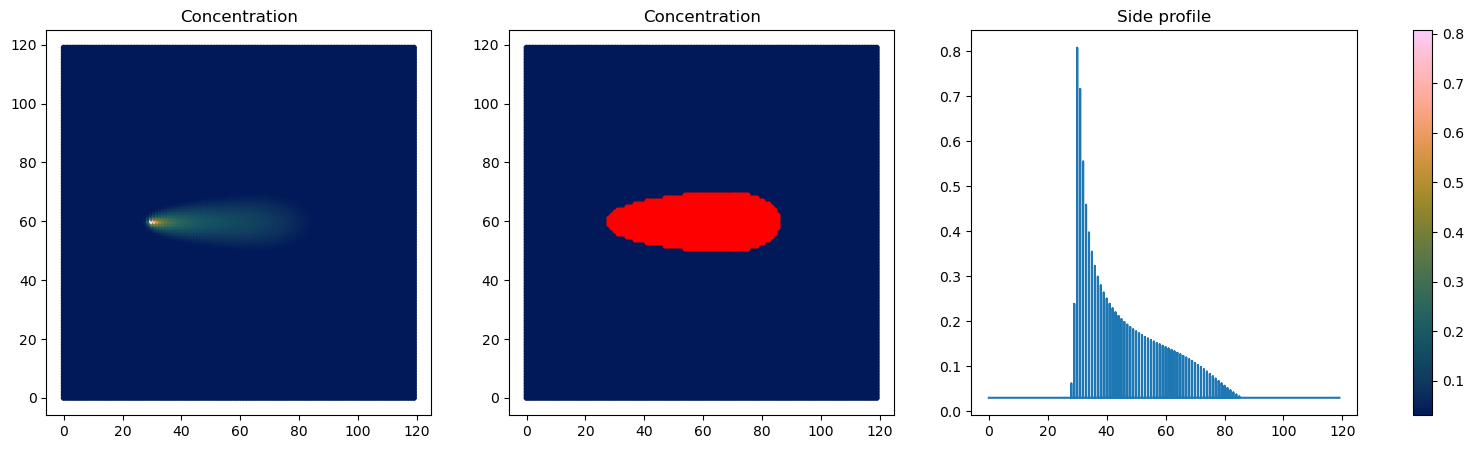

In [36]:
# Plot the function

x = x_advection
y = y_advection
values = values_advection

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Concentration")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[values > 0.03], y[values > 0.03], c="r", s=12)
axs[1].set_title("Concentration")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x, values)
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)


plt.show()

### Cylinder

In [37]:
# Define the function in polar coordinates

cylinder_function_polar = lambda r: np.where(r < 4, 16, 1)


meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = cylinder_function_polar(R)


points_cylinder = np.array([x, y]).T
x_cylinder = x
y_cylinder = y
meshgrid_cylinder = meshgrid
values_cylinder = values
labels_cylinder = values > 1

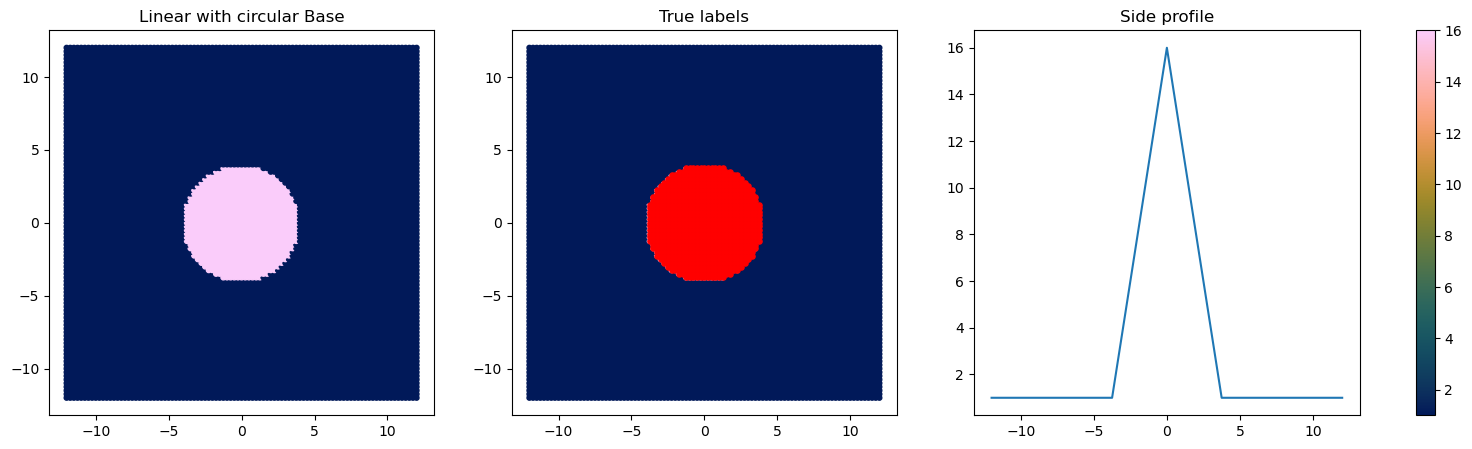

In [38]:
# With polar coordinates, so that the base is circular

x = x_cylinder
y = y_cylinder
values = values_cylinder
labels = labels_cylinder


# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

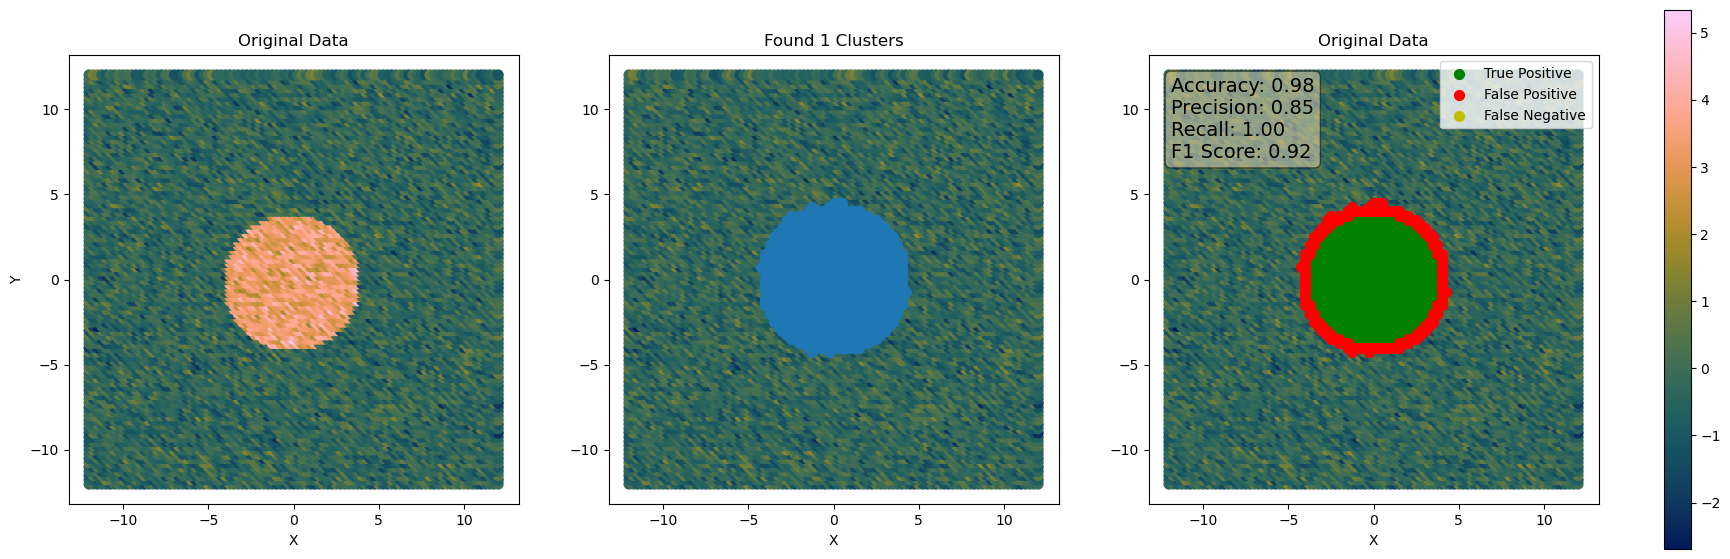

In [39]:
# Example

values = values_cylinder
points = points_cylinder
labels = labels_cylinder

noise_sigma = 0.6
radius_func_sigmas_threshold = 0.4

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=50,
)

### Triangles

In [40]:
def check_points_in_triangle_vectorized(points, v1, v2, v3):
    """
    Check if each point in the array `points` (shape: [n, 2])
    is inside the triangle defined by v1, v2, v3.

    Returns:
        A boolean NumPy array of shape (n,) where True means inside.
    """
    points = np.asarray(points)
    # v1 = np.asarray(v1)
    # v2 = np.asarray(v2)
    # v3 = np.asarray(v3)

    # Compute the "sign" values for each edge, for all points
    d1 = (points[:, 0] - v2[0]) * (v1[1] - v2[1]) - (v1[0] - v2[0]) * (
        points[:, 1] - v2[1]
    )
    d2 = (points[:, 0] - v3[0]) * (v2[1] - v3[1]) - (v2[0] - v3[0]) * (
        points[:, 1] - v3[1]
    )
    d3 = (points[:, 0] - v1[0]) * (v3[1] - v1[1]) - (v3[0] - v1[0]) * (
        points[:, 1] - v1[1]
    )

    # A point is inside if it is on the same side of all three edges.
    inside = ((d1 >= 0) & (d2 >= 0) & (d3 >= 0)) | ((d1 <= 0) & (d2 <= 0) & (d3 <= 0))
    return inside


# Example usage:
triangle = ((1, 2), (4, 8), (7, 2))
points = np.array([[4, 4], [8, 8], [3, 3], [2, 2]])
results = check_points_in_triangle_vectorized(points, *triangle)

for pt, inside in zip(points, results):
    status = "inside" if inside else "outside"
    print(f"Point {pt} is {status} the triangle.")

Point [4 4] is inside the triangle.
Point [8 8] is outside the triangle.
Point [3 3] is inside the triangle.
Point [2 2] is inside the triangle.


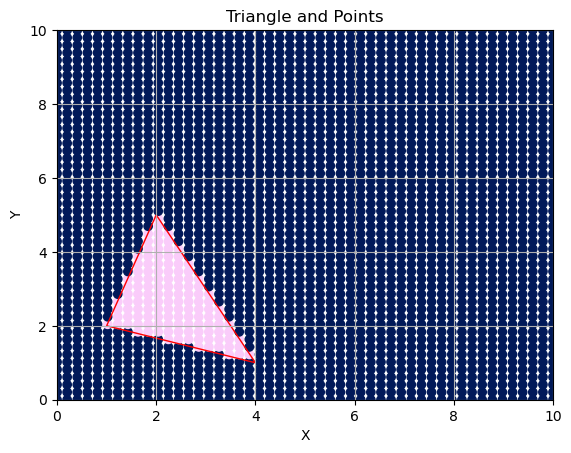

In [41]:
# Define the triangle vertices and points
triangle = ((2, 5), (4, 1), (1, 2))

points = np.array([[4, 4], [8, 8], [3, 3], [2, 2]])
meshgrid = np.meshgrid(np.linspace(0, 10, 50), np.linspace(0, 10, 50))
points = np.array(meshgrid).reshape(2, -1).T

results = check_points_in_triangle_vectorized(points, *triangle)

# Create a plot
fig, ax = plt.subplots()

# Plot the points
ax.scatter(
    points[:, 0], points[:, 1], c=results.astype(int)
)  # 'bo' means blue color, circle markers

# Set plot limits
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Plot the triangle
triangle_patch = Polygon(triangle, closed=True, fill=None, edgecolor="r")
ax.add_patch(triangle_patch)

# Add labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Triangle and Points")

# Show the plot
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'test data5')

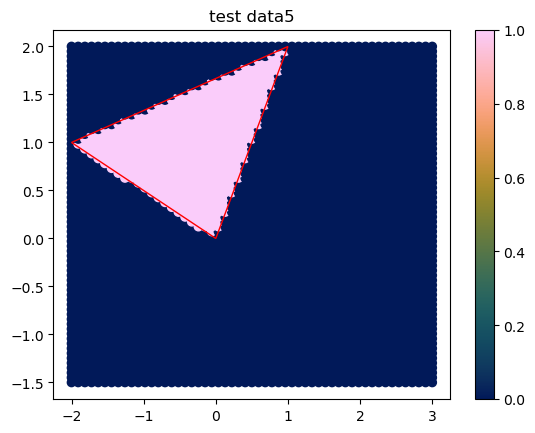

In [42]:
meshgrid = np.meshgrid(np.linspace(-2, 3, 55), np.linspace(-1.5, 2, 70))
points = np.array(meshgrid).reshape(2, -1).T

triangle = ((0, 0), (1, 2), (-2, 1))

results = check_points_in_triangle_vectorized(points, *triangle)

# Create a plot
fig, ax = plt.subplots()

plt.scatter(points[:, 0], points[:, 1], c=results)

# Plot the triangle
triangle_patch = Polygon(triangle, closed=True, fill=None, edgecolor="r")
ax.add_patch(triangle_patch)

plt.colorbar()
plt.title("test data5")

### Plots

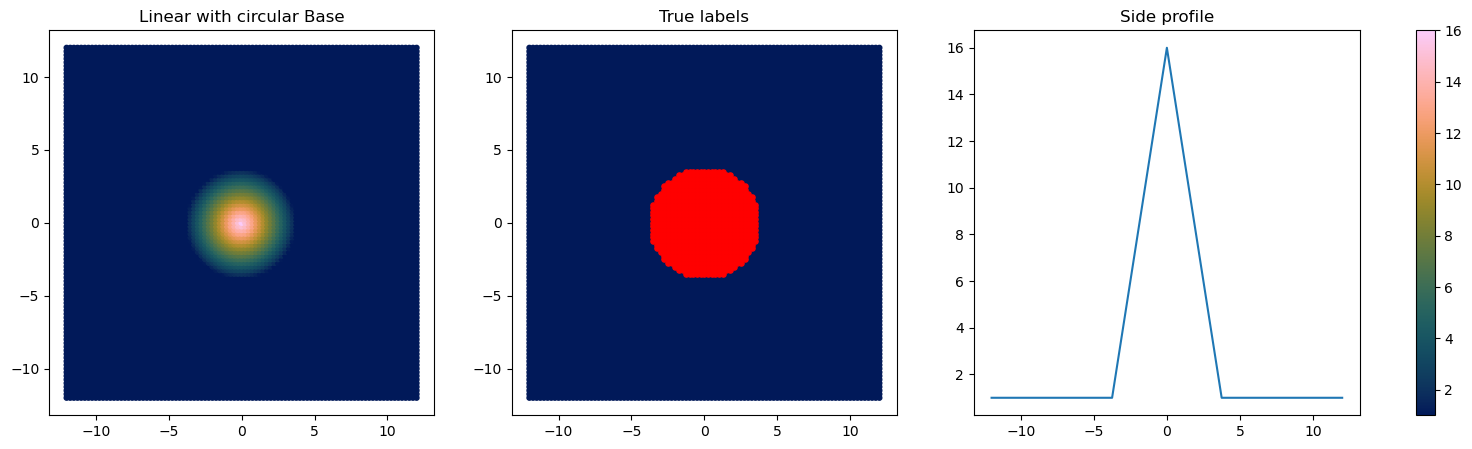

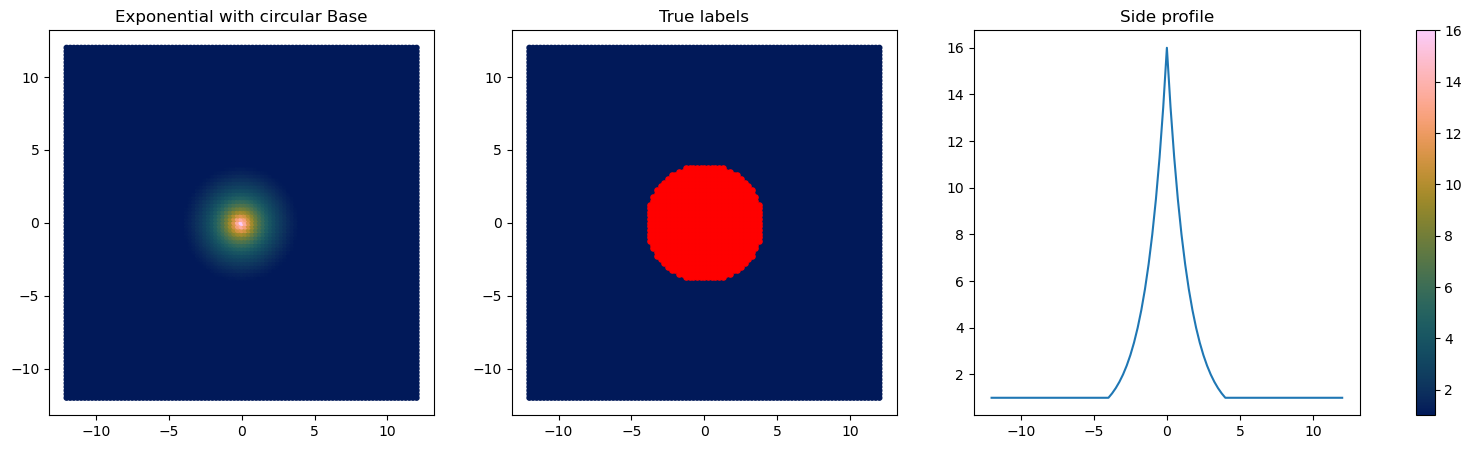

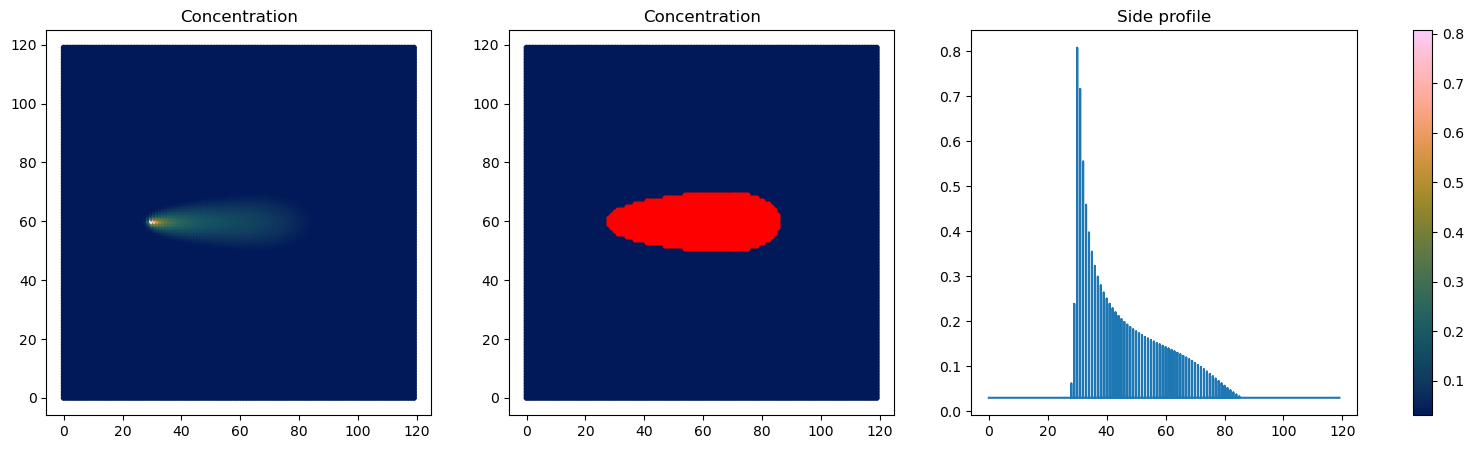

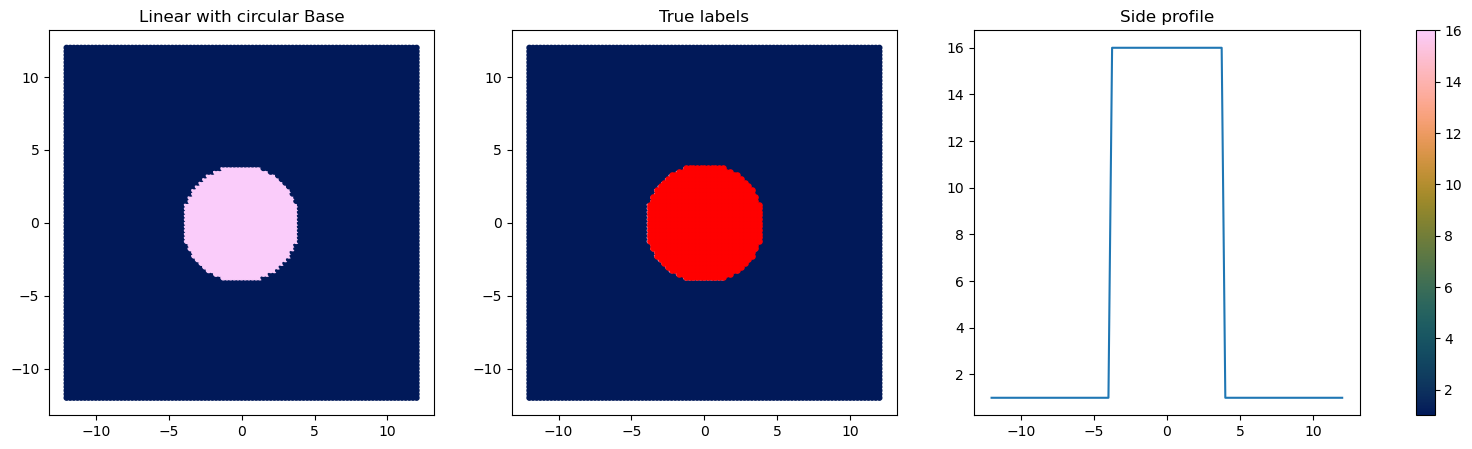

In [101]:
# With polar coordinates, so that the base is circular

# Define the polar linear data
# Define the function in polar coordinates

linear_function_polar = lambda r: np.maximum(-r * 4 + 16, 1)

meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = linear_function_polar(R)


class_colors = ["red", "red", "red"]
cmap_class = ListedColormap(class_colors)
norm_class = BoundaryNorm([0.5, 1.5, 2.5, 3.5], len(class_colors))


points_linear_polar = np.array([x, y]).T
x_linear_polar = x
y_linear_polar = y
meshgrid_linear_polar = meshgrid
values_linear_polar = values
labels_linear_polar = values > 1

x = x_linear_polar
y = y_linear_polar
values = values_linear_polar
labels = labels_linear_polar


# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()


####
# Version 2


# Define the polar exponential data
exponential_decrease_continuous = lambda x: np.min(
    [2 ** (-x + 2), 2 ** (+x + 2)], axis=0
)
exponential_decrease = lambda x, y: np.maximum(
    exponential_decrease_continuous(x) * exponential_decrease_continuous(y), 1
)

exponential_function_polar = lambda r: np.maximum(2 ** (-r + 4), 1)

meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = exponential_function_polar(R)

points_exponential_polar = np.array([x, y]).T
x_exponential_polar = x
y_exponential_polar = y
meshgrid_exponential_polar = meshgrid
values_exponential_polar = values
labels_exponential_polar = values > 1

# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Exponential with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels_exponential_polar], y[labels_exponential_polar], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], exponential_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()


####

coordinates = np.array(coordinates)
x_advection = coordinates[:, 0]
y_advection = coordinates[:, 1]
points_advection = np.array([x_advection, y_advection]).T
values_advection = coordinates[:, 2]
labels_advection = values_advection > 0.03

# Plot the function

x = x_advection
y = y_advection
values = values_advection

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Concentration")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[values > 0.03], y[values > 0.03], c="r", s=12)
axs[1].set_title("Concentration")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x, values)
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)


plt.show()


####


# Define the function in polar coordinates

cylinder_function_polar = lambda r: np.where(r < 4, 16, 1)


meshgrid = np.meshgrid(np.linspace(-12, 12, 97), np.linspace(-12, 12, 97))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = cylinder_function_polar(R)


points_cylinder = np.array([x, y]).T
x_cylinder = x
y_cylinder = y
meshgrid_cylinder = meshgrid
values_cylinder = values
labels_cylinder = values > 1


# With polar coordinates, so that the base is circular

x = x_cylinder
y = y_cylinder
values = values_cylinder
labels = labels_cylinder


# Plot the function
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
axs[1].scatter(x[labels], y[labels], s=14, c="r")
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

# 3rd plot
axs[2].plot(x[np.where(y == 0)], cylinder_function_polar(R[np.where(y == 0)]))
axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

plt.show()

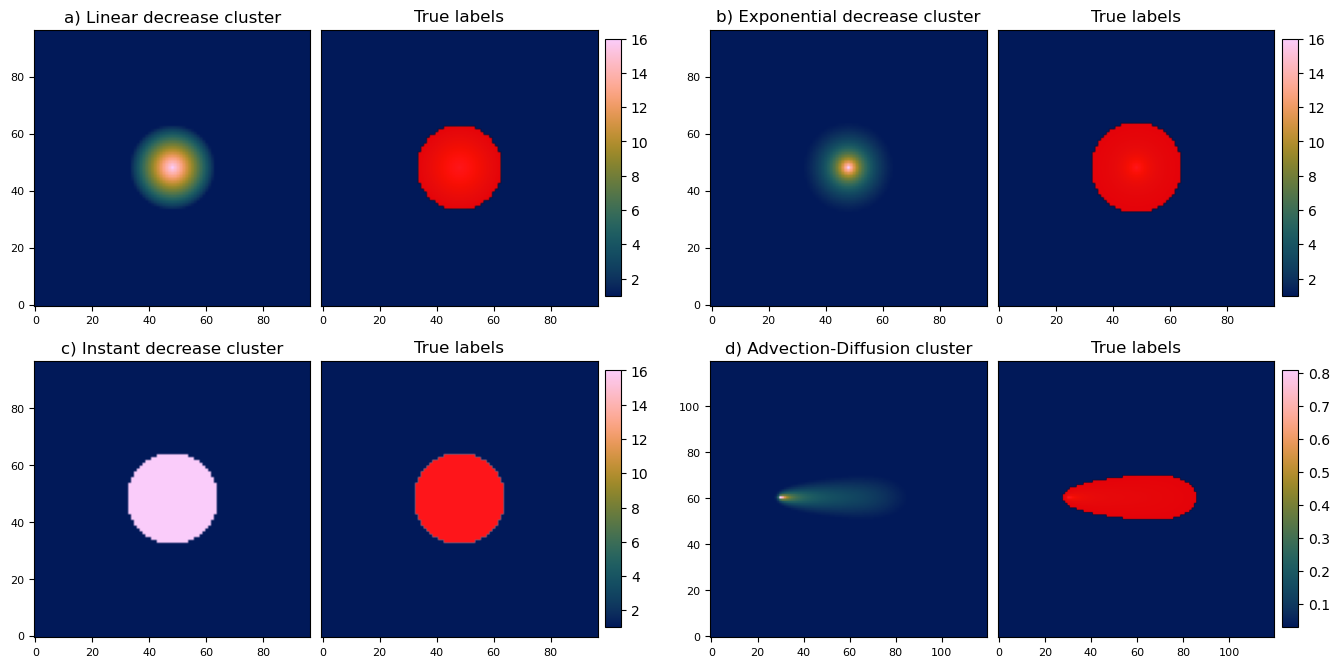

In [102]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def points_to_image_matrix(
    points,
    values,
    labels,
):
    # Determine grid dimensions from point coordinates.
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    width = len(unique_x)
    height = len(unique_y)

    # Create a mapping from coordinates to grid indices.
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize images (2D arrays) with NaN so that missing pixels remain blank.
    img_orig = np.full((height, width), np.nan)
    img_labels = np.full((height, width), np.nan)

    # Populate the image arrays.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        # Original image: assign the value.
        img_orig[row, col] = values[i]

        # Clusters: only assign if cluster is nonzero.
        if labels[i]:
            img_labels[row, col] = labels[i]
        
    # Return the images.
    return img_orig, img_labels





fig = plt.figure(figsize=(16, 8.4))

# Create a main grid with 2 rows
gs_main = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.05)

gs_top_left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[0], wspace=0.04, hspace=0.05)
ax0 = fig.add_subplot(gs_top_left[0])
ax1 = fig.add_subplot(gs_top_left[1])

gs_top_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[1], wspace=0.04, hspace=0.05)
ax2 = fig.add_subplot(gs_top_right[0])
ax3 = fig.add_subplot(gs_top_right[1])

gs_bottom_left = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[2], wspace=0.04, hspace=0.05)
ax4 = fig.add_subplot(gs_bottom_left[0])
ax5 = fig.add_subplot(gs_bottom_left[1])

gs_bottom_right = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_main[3], wspace=0.04,  hspace=0.05)
ax6 = fig.add_subplot(gs_bottom_right[0])
ax7 = fig.add_subplot(gs_bottom_right[1])


img_linear_polar, img_linear_labels = points_to_image_matrix(
    points_linear_polar,
    values_linear_polar,
    labels_linear_polar,
)
img_exponential_polar, img_exponential_labels = points_to_image_matrix(
    points_exponential_polar,
    values_exponential_polar,
    labels_exponential_polar,
)
img_cylinder, img_cylinder_labels = points_to_image_matrix(
    points_cylinder,
    values_cylinder,
    labels_cylinder,
)
img_advection, img_advection_labels = points_to_image_matrix(
    points_advection,
    values_advection,
    labels_advection,
)

# Now you can plot into ax0, ax1, ax2, ax3 as you did before.
# For example:
ax0.imshow(img_linear_polar, origin="lower")
ax0.set_title("a) Linear decrease cluster")
asdf = ax1.imshow(img_linear_polar, origin="lower")
ax1.imshow(img_linear_labels, origin="lower", cmap=cmap_class, norm=norm_class, alpha=0.9)
ax1.set_title("True labels")
ax1.set_yticks([])

ax2.imshow(img_exponential_polar, origin="lower")
ax2.set_title("b) Exponential decrease cluster")
ax3.imshow(img_exponential_polar, origin="lower")
ax3.imshow(img_exponential_labels, origin="lower", cmap=cmap_class, norm=norm_class, alpha=0.9)
ax3.set_title("True labels")
ax3.set_yticks([])

ax4.imshow(img_cylinder, origin="lower")
ax4.set_title("c) Instant decrease cluster")
ax5.imshow(img_cylinder, origin="lower")
ax5.imshow(img_cylinder_labels, origin="lower", cmap=cmap_class, norm=norm_class, alpha=0.9)
ax5.set_title("True labels")
ax5.set_yticks([])

ax6.imshow(img_advection, origin="lower")
ax6.set_title("d) Advection-Diffusion cluster")
ax7.imshow(img_advection, origin="lower")
ax7.imshow(img_advection_labels, origin="lower", cmap=cmap_class, norm=norm_class, alpha=0.9)
ax7.set_title("True labels")
ax7.set_yticks([])

for ax in [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust the labelsize as needed


# For the first pair (ax0 and ax1)
cbar_ax1 = fig.add_axes([0.905, 0.54, 0.01, 0.306])  # Adjust these values as needed
cbar1 = plt.colorbar(ax0.images[0], cax=cbar_ax1)

# For the second pair (ax2 and ax3)
cbar_ax2 = fig.add_axes([0.905, 0.145, 0.01, 0.306])  # Adjust these values as needed
cbar2 = plt.colorbar(ax6.images[0], cax=cbar_ax2)

# Similarly, for the remaining pairs:
cbar_ax3 = fig.add_axes([0.482, 0.54, 0.01, 0.306])  # Example positions; adjust as necessary
cbar3 = plt.colorbar(ax2.images[0], cax=cbar_ax3)

cbar_ax4 = fig.add_axes([0.482, 0.145, 0.01, 0.306])  # Example positions; adjust as necessary
cbar4 = plt.colorbar(ax4.images[0], cax=cbar_ax4)

# Save figure
plt.savefig(plots_path / "test_data.pdf", bbox_inches="tight", transparent=True, format="pdf")

plt.show()


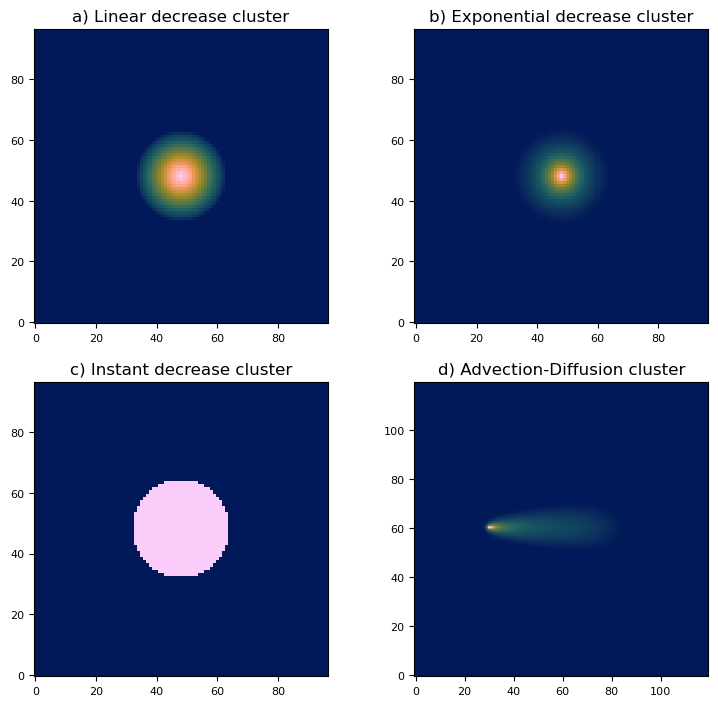

In [113]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def points_to_image_matrix(
    points,
    values,
    labels,
):
    # Determine grid dimensions from point coordinates.
    unique_x = np.unique(points[:, 0])
    unique_y = np.unique(points[:, 1])
    width = len(unique_x)
    height = len(unique_y)

    # Create a mapping from coordinates to grid indices.
    x_to_index = {x: idx for idx, x in enumerate(unique_x)}
    y_to_index = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize images (2D arrays) with NaN so that missing pixels remain blank.
    img_orig = np.full((height, width), np.nan)
    img_labels = np.full((height, width), np.nan)

    # Populate the image arrays.
    for i in range(points.shape[0]):
        col = x_to_index[points[i, 0]]
        row = y_to_index[points[i, 1]]
        # Original image: assign the value.
        img_orig[row, col] = values[i]

        # Clusters: only assign if cluster is nonzero.
        if labels[i]:
            img_labels[row, col] = labels[i]
        
    # Return the images.
    return img_orig, img_labels





fig = plt.figure(figsize=(9, 8.4))

# Create a main grid with 2 rows
gs_main = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

gs_top_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0],)
ax0 = fig.add_subplot(gs_top_left[0])

gs_top_right = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs_top_right[0])

gs_bottom_left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax4 = fig.add_subplot(gs_bottom_left[0])

gs_bottom_right = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[3])
ax6 = fig.add_subplot(gs_bottom_right[0])


img_linear_polar, img_linear_labels = points_to_image_matrix(
    points_linear_polar,
    values_linear_polar,
    labels_linear_polar,
)
img_exponential_polar, img_exponential_labels = points_to_image_matrix(
    points_exponential_polar,
    values_exponential_polar,
    labels_exponential_polar,
)
img_cylinder, img_cylinder_labels = points_to_image_matrix(
    points_cylinder,
    values_cylinder,
    labels_cylinder,
)
img_advection, img_advection_labels = points_to_image_matrix(
    points_advection,
    values_advection,
    labels_advection,
)

# Now you can plot into ax0, ax1, ax2, ax3 as you did before.
# For example:
ax0.imshow(img_linear_polar, origin="lower")
ax0.set_title("a) Linear decrease cluster")

ax2.imshow(img_exponential_polar, origin="lower")
ax2.set_title("b) Exponential decrease cluster")

ax4.imshow(img_cylinder, origin="lower")
ax4.set_title("c) Instant decrease cluster")

ax6.imshow(img_advection, origin="lower")
ax6.set_title("d) Advection-Diffusion cluster")

for ax in [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust the labelsize as needed




# Save figure
plt.savefig(plots_path / "test_data.pdf", bbox_inches="tight", transparent=True, format="pdf")

plt.show()


## Experiment with single cluster on effects of sensitivity and noise

- How well does it find the correct points?
- Does it find the correct number of points?


There are many things that affect the preformance
- How much there is the background areas compared to high valued areas.
- How high is the peak compared to the background levels
- Parameters of SCEA
    - Sensitivity on size of plumes
    - Sensitivity on number of plumes
- Noise levels

### Single polynomial plume with noise

In [ ]:
points_polynomial = np.array([x_polynomial, y_polynomial]).T

In [ ]:
clusters_polynomial = SCEA.scea(
    points_polynomial,
    values_polynomial,
    radius_func="default",
    n_clusters="auto",
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=1,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=True,
)


plot_clusters(
    points_polynomial,
    values_polynomial,
    clusters_polynomial,
    labels_polynomial,
    s=50,
)

In [ ]:
noise_levels = np.arange(0, 3.1, 0.2)  # Standard deviations of the noise

# First standardize data set
values_polynomial_standardized = (
    values_polynomial - values_polynomial.mean()
) / values_polynomial.std()

f1_score_averages = [0] * len(noise_levels)

for i, noise_sigma in enumerate(noise_levels):

    n_repetitions_per_noise_level = 5
    f1_scores = [0] * n_repetitions_per_noise_level
    for j in range(n_repetitions_per_noise_level):
        # add noise
        values_polynomial_noisy = values_polynomial_standardized + np.random.normal(
            0, noise_sigma, values_polynomial.shape
        )

        # cluster
        clusters = SCEA.scea(
            points_polynomial,
            values_polynomial_noisy,
            radius_func="default",
            n_clusters="auto",
            point_value_threshold="stds_from_median",
            stds=3.5,
            distance_matrix="euclidean",
            radius_func_sigmas_threshold=1,
            max_points_in_start_radius=6,
            local_box_size=0,
            verbose=False,
        )

        # calculate metrics
        tp, fp, tn, fn = classification_outcomes(
            clusters, labels_polynomial, reutrn_counts=True
        )
        f1 = 2 * tp / (2 * tp + fp + fn)
        f1_scores[j] = f1

    f1_score_averages[i] = np.mean(f1_scores)

    if i % 10 == 0:
        print(f"Sigma: {noise_sigma:.2f}, F1_average: {f1_score_averages[i]:.2f}")
        plot_clusters(
            points_polynomial,
            values_polynomial_noisy,
            clusters,
            labels_polynomial,
            s=50,
        )

In [ ]:
f1_score_averages

### Linear 

In [ ]:
# Example

values = values_linear
points = points_linear
labels = labels_linear

noise_sigma = 5
radius_func_sigmas_threshold = 1

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=50,
)

In [ ]:
values = values_linear
points = points_linear
labels = labels_linear

noise_levels = np.arange(0, 10.1, 0.1)  # Standard deviations of the noise

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

f1_score_averages = [0] * len(noise_levels)

for i, noise_sigma in enumerate(noise_levels):

    n_repetitions_per_noise_level = 50
    f1_scores = [0] * n_repetitions_per_noise_level
    for j in range(n_repetitions_per_noise_level):
        # add noise
        values_noisy = values_standardized + np.random.normal(
            0, noise_sigma, values.shape
        )

        # cluster
        clusters = SCEA.scea(
            points,
            values_noisy,
            radius_func="default",
            n_clusters="auto",
            point_value_threshold="stds_from_median",
            stds=3.5,
            distance_matrix="euclidean",
            radius_func_sigmas_threshold=1,
            max_points_in_start_radius=6,
            local_box_size=0,
            verbose=False,
        )

        # calculate metrics
        tp, fp, tn, fn = classification_outcomes(clusters, labels, reutrn_counts=True)
        f1 = 2 * tp / (2 * tp + fp + fn)
        f1_scores[j] = f1

    f1_score_averages[i] = np.mean(f1_scores)

    # if i%10==0:
    #    print(f"Sigma: {sigma:.2f}, F1_average: {f1_score_averages[i]:.2f}")
    #    plot_clusters(points, values_noisy, clusters, labels, s=50,)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))


xx = np.linspace(-40, 39, 80)
values_linear_side = -abs(xx) + 10
values_linear_side[values_linear_side < 0] = 0
peak = 10
ax[0].plot(xx, values_linear_side)
ax[0].set_title(f"Side profile, with peak of {peak}")


ax[1].plot(noise_levels, f1_score_averages)
ax[1].set_xlabel("Noise level")
ax[1].set_ylabel("F1 score")
ax[1].set_title("F1 score vs. noise level")
ax[1].grid(True)
ax[1].set_ylim(0, 1)

Same but with set to find only one plume

In [ ]:
values = values_linear
points = points_linear
labels = labels_linear

noise_levels = np.arange(0, 10.1, 0.1)  # Standard deviations of the noise

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

f1_score_averages = [0] * len(noise_levels)

for i, noise_sigma in enumerate(noise_levels):

    n_repetitions_per_noise_level = 10
    f1_scores = [0] * n_repetitions_per_noise_level
    for j in range(n_repetitions_per_noise_level):
        # add noise
        values_noisy = values_standardized + np.random.normal(
            0, noise_sigma, values.shape
        )

        # cluster
        clusters = SCEA.scea(
            points,
            values_noisy,
            radius_func="default",
            n_clusters=1,
            point_value_threshold="stds_from_median",
            stds=3.5,
            distance_matrix="euclidean",
            radius_func_sigmas_threshold=1,
            max_points_in_start_radius=6,
            local_box_size=0,
            verbose=False,
        )

        # calculate metrics
        tp, fp, tn, fn = classification_outcomes(clusters, labels, reutrn_counts=True)
        f1 = 2 * tp / (2 * tp + fp + fn)
        f1_scores[j] = f1

    f1_score_averages[i] = np.mean(f1_scores)

    # if i%10==0:
    #    print(f"Sigma: {sigma:.2f}, F1_average: {f1_score_averages[i]:.2f}")
    #    plot_clusters(points, values_noisy, clusters, labels, s=50,)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(noise_levels, f1_score_averages)
ax.set_xlabel("Noise level")
ax.set_ylabel("F1 score")
ax.set_title("F1 score vs. noise level. With 1 cluster")
ax.grid(True)
ax.set_ylim(0, 1)

plt.show()

With different parameters radius func parameters

In [ ]:
values = values_linear
points = points_linear
labels = labels_linear

noise_levels = np.arange(0, 10.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 10
radius_func_sigmas_thresholds = np.arange(0.2, 3.1, 0.1)

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level
        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)

In [ ]:
np.save("scores_per_radius_func_s.npy", scores_per_radius_func_s)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

for i, radius_func_s in enumerate(radius_func_sigmas_thresholds):
    if i % 4 == 0:
        ax.plot(
            noise_levels,
            scores_per_radius_func_s[i],
            label=f"Radius func sigma: {radius_func_s:.2f}",
        )
ax.set_xlabel("Noise level, standard deviations")
ax.set_ylabel("F1 score")
ax.set_title("F1 score vs. noise level, with different radius_func_sigma parameters.")
ax.grid(True)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

In [ ]:
# Plot this in a 2-D heatmap

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

scores_per_radius_func_s = np.array(scores_per_radius_func_s)
cax = ax.matshow(scores_per_radius_func_s, vmin=0, vmax=1)
cbar = fig.colorbar(cax)
cbar.set_label("F1 score")

# Set ticks for every point
xticks = np.arange(len(noise_levels))
yticks = np.arange(len(radius_func_sigmas_thresholds))

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Set labels for every other tick
ax.set_xticklabels(
    [str(label) if i % 2 == 0 else "" for i, label in enumerate(noise_levels.round(4))]
)
ax.set_yticklabels(
    [
        str(label) if i % 2 == 0 else ""
        for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
    ]
)

# Lower the font size of the tick labels and rotate them
ax.tick_params(axis="both", which="major", labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


ax.set_xlabel("Noise level")
ax.set_ylabel("Radius func sigma")

ax.set_title("Heatmap of F1 scores")

plt.show()

In [ ]:
scores_per_radius_func_s

In [ ]:
[""] + list(noise_levels.round(4))

#### Failed different sized peaks experiment

In [ ]:
# values = values_linear
# points = points_linear
labels = labels_linear

peaks = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.5, 0.4, 0.3, 0.2, 0.1]
n_repetitions_per_noise_level = 5
noise_levels = np.arange(0, 5.1, 0.5)  # Standard deviations of the noise


f1_score_averages_for_peaks = []

# Iterate over peak sizes
for peak in peaks:

    divide_by = 10 / peak
    values = values_linear / divide_by

    # First standardize data set
    values_standardized = (values - values.mean()) / values.std()

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level

        # Repeat one noise level multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values_standardized.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters="auto",
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=1,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

        # if i%10==0:
        #    print(f"Sigma: {sigma:.2f}, F1_average: {f1_score_averages[i]:.2f}")
        #    plot_clusters(points, values_noisy, clusters, labels, s=50,)

    f1_score_averages_for_peaks.append(f1_score_averages)

In [ ]:
for i in range(len(peaks)):
    fig, ax = plt.subplots(1, 2, figsize=(12, 2))

    divide_by = 10 / peaks[i]
    ax[0].plot(xx, values_linear_side / divide_by)
    ax[0].set_title(f"Side profile, with peak of {peaks[i]}")
    ax[0].set_ylim(-0.1, 10.1)

    ax[1].plot(noise_levels, f1_score_averages_for_peaks[i])
    ax[1].set_xlabel("Noise level")
    ax[1].set_ylabel("F1 score")
    ax[1].set_title("F1 score vs. noise level")
    ax[1].set_ylim(0, 1.01)

    plt.show()

In [ ]:
peaks = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.5, 0.4, 0.3, 0.2, 0.1]
n_repetitions_per_noise_level = 5
noise_levels = np.arange(0, 5.1, 0.5)  # Standard deviations of the noise


f1_score_averages_for_peaks = []

# Iterate over peak sizes

peak = 1

divide_by = 10 / peak
values = values_linear / divide_by

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

In [ ]:
plt.scatter(points[:, 0], points[:, 1], c=values)
plt.colorbar()

In [ ]:
peak = 10
divide_by = 10 / peak
values = values_linear + 1
values = values / divide_by
values.mean()

In [ ]:
values.std()

In [ ]:
((values - values.mean()) / values.std()).max()

In [ ]:
# or just linear
meshgrid = np.meshgrid(np.linspace(-20, 19, 40), np.linspace(-20, 19, 40))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
values = -abs(x) - abs(y) + 10
values[values < 0] = 0
values = values + 100

values_linear = values
points_linear = np.array([x, y]).T


fig, axs = plt.subplots(1, 1, figsize=(5, 5))
# axs = axs.flatten()

# 1st plot
sc = axs.scatter(x, y, c=values, s=50)
axs.set_title("Linear")

# colorbar
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)


# 2nd plot
# is_positive = values>0
# axs[1].scatter(x,y, c=values, s=50)
# axs[1].scatter(x[is_positive],y[is_positive], s=16, c='r')
# axs[1].set_title("Positive values")
plt.colorbar

labels_linear = is_positive

In [ ]:
peak = 1
divide_by = 10 / peak
values = values_linear + 1
values = values / divide_by
values.mean()

In [ ]:
((values - values.mean()) / values.std()).max()

### Polynomial plume

In [ ]:
# Example

values = values_polynomial
points = points_polynomial
labels = labels_polynomial

noise_sigma = 0.2
radius_func_sigmas_threshold = 0.8

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=50,
)

In [ ]:
# The big run

values = values_polynomial
points = points_polynomial
labels = labels_polynomial

noise_levels = np.arange(0, 10.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 12
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level
        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)

In [ ]:
np.save("scores_per_radius_func_s_polynomial_plume.npy", scores_per_radius_func_s)

In [ ]:
# Plot this in a 2-D heatmap

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

scores_per_radius_func_s = np.array(scores_per_radius_func_s)
cax = ax.matshow(scores_per_radius_func_s, vmin=0, vmax=1)
cbar = fig.colorbar(cax)
cbar.set_label("F1 score")

# Set ticks for every point
xticks = np.arange(len(noise_levels))
yticks = np.arange(len(radius_func_sigmas_thresholds))

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Set labels for every other tick
ax.set_xticklabels(
    [str(label) if i % 2 == 0 else "" for i, label in enumerate(noise_levels.round(4))]
)
ax.set_yticklabels(
    [
        str(label) if i % 2 == 0 else ""
        for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
    ]
)

# Lower the font size of the tick labels and rotate them
ax.tick_params(axis="both", which="major", labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


ax.set_xlabel("Noise level")
ax.set_ylabel("Radius func sigma")

ax.set_title("Heatmap of F1 scores")

plt.show()

In [ ]:
# Current time
import datetime

print(datetime.datetime.now().strftime("%y-%m-%d_%H-%M"))

### Linear polar

In [ ]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar

noise_sigma = 3
radius_func_sigmas_threshold = 0.6

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters_imshow_2(
    points,
    values,
    values_noisy,
    clusters,
    labels,
    s=50,
    vmin=values_noisy.min(),
    vmax=values_noisy.max(),
)

In [ ]:
# The big run

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar
filename = (
    "scores_per_radiusfuncs_noise_linearpolar_"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)


# First standardize data set
values_standardized = (values - values.mean()) / values.std()

scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level
        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)


np.save(outputs_path / filename, scores_per_radius_func_s)

In [ ]:
filename = "scores_per_radiusfuncs_noise_linearpolar_25-02-28_18-26.npy"
scores_per_radius_func_s = np.load(outputs_path / filename)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

plot_heatmap(
    scores_per_radius_func_s,
    noise_levels,
    radius_func_sigmas_thresholds,
    title="a) Linear decrease cluster",
    y_label="Radius Function Sensitivitiy \n",
    best_param_box_size=80,
    save_to= plots_path / "heatmap_radiusfuncs_noise_linear_decrease.pdf",
)

### Exponential polar

In [ ]:
# Example

values = values_exponential_polar
points = points_exponential_polar
labels = labels_exponential_polar

noise_sigma = 3
radius_func_sigmas_threshold = 0.6

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=50,
)

In [ ]:
# The big run

values = values_exponential_polar
points = points_exponential_polar
labels = labels_exponential_polar
filename = (
    "scores_per_radiusfuncs_noise_exponentialpolar_"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level
        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)


np.save(outputs_path / filename, scores_per_radius_func_s)

In [ ]:
filename = "scores_per_radiusfuncs_noise_exponentialpolar_25-02-28_23-58.npy"
scores_per_radius_func_s = np.load(outputs_path / filename)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

plot_heatmap(
    scores_per_radius_func_s,
    noise_levels,
    radius_func_sigmas_thresholds,
    title="b) Exponential decrease cluster",
    y_label="Radius Function Sensitivitiy \n",
    best_param_box_size=80,
    #save_to= plots_path / "heatmap_radiusfuncs_noise_exponential_decrease.pdf",
)

### Cylinder

In [ ]:
# Example

values = values_cylinder
points = points_cylinder
labels = labels_cylinder

noise_sigma = 3
radius_func_sigmas_threshold = 0.6

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=50,
)

In [ ]:
# The big run

values = values_cylinder
points = points_cylinder
labels = labels_cylinder
filename = (
    "scores_per_radiusfuncs_noise_cylinder_"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)


# First standardize data set
values_standardized = (values - values.mean()) / values.std()

scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level
        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)


np.save(outputs_path / filename, scores_per_radius_func_s)

In [ ]:
# Plot this in a 2-D heatmap

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

scores_per_radius_func_s = np.array(scores_per_radius_func_s)
cax = ax.matshow(scores_per_radius_func_s, vmin=0, vmax=1)
cbar = fig.colorbar(cax)
cbar.set_label("F1 score")

# Set ticks for every point
xticks = np.arange(len(noise_levels))
yticks = np.arange(len(radius_func_sigmas_thresholds))

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Set labels for every other tick
ax.set_xticklabels(
    [str(label) if i % 2 == 0 else "" for i, label in enumerate(noise_levels.round(4))]
)
ax.set_yticklabels(
    [
        str(label) if i % 2 == 0 else ""
        for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
    ]
)

# Lower the font size of the tick labels and rotate them
ax.tick_params(axis="both", which="major", labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


ax.set_xlabel("Noise level")
ax.set_ylabel("Radius func sigma")

ax.set_title("Heatmap of F1 scores")

plt.show()

In [ ]:
filename = "scores_per_radiusfuncs_noise_cylinder_25-03-01_05-40.npy"
scores_per_radius_func_s = np.load(outputs_path / filename)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

plot_heatmap(
    scores_per_radius_func_s,
    noise_levels,
    radius_func_sigmas_thresholds,
    title="c) Instant decrease cluster",
    y_label="Radius Function Sensitivitiy \n",
    best_param_box_size=80,
    #save_to= plots_path / "heatmap_radiusfuncs_noise_instant_decrease.pdf",
)

### Advection-diffution plume

In [ ]:
# Example

values = values_advection
points = points_advection
labels = labels_advection

noise_sigma = 3
radius_func_sigmas_threshold = 0

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters(
    points,
    values_noisy,
    clusters,
    labels,
    s=10,
)

In [ ]:
# The big run

values = values_advection
points = points_advection
labels = labels_advection
filename = (
    "scores_per_radiusfuncs_noise_advectiondiffusion_"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 15
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)


# First standardize data set
values_standardized = (values - values.mean()) / values.std()
scores_per_radius_func_s = []

# Iterate over radius_func_sigmas_thresholds
for k, radius_func_s in enumerate(tqdm(radius_func_sigmas_thresholds)):

    f1_score_averages = [0] * len(noise_levels)

    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_scores = [0] * n_repetitions_per_noise_level

        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            # add noise
            values_noisy = values_standardized + np.random.normal(
                0, noise_sigma, values.shape
            )

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters=1,
                point_value_threshold="stds_from_median",
                stds=3.5,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_s,
                max_points_in_start_radius=6,
                local_box_size=0,
                verbose=False,
            )

            # calculate metrics
            tp, fp, tn, fn = classification_outcomes(
                clusters, labels, reutrn_counts=True
            )
            f1 = 2 * tp / (2 * tp + fp + fn)
            f1_scores[j] = f1

        f1_score_averages[i] = np.mean(f1_scores)

    scores_per_radius_func_s.append(f1_score_averages)


np.save(outputs_path / filename, scores_per_radius_func_s)

In [ ]:
# Plot this in a 2-D heatmap

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

scores_per_radius_func_s = np.array(scores_per_radius_func_s)
cax = ax.matshow(scores_per_radius_func_s, vmin=0, vmax=1)
cbar = fig.colorbar(cax)
cbar.set_label("F1 score")

# Set ticks for every point
xticks = np.arange(len(noise_levels))
yticks = np.arange(len(radius_func_sigmas_thresholds))

ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Set labels for every other tick
ax.set_xticklabels(
    [str(label) if i % 2 == 0 else "" for i, label in enumerate(noise_levels.round(4))]
)
ax.set_yticklabels(
    [
        str(label) if i % 2 == 0 else ""
        for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
    ]
)

# Lower the font size of the tick labels and rotate them
ax.tick_params(axis="both", which="major", labelsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")


ax.set_xlabel("Noise level")
ax.set_ylabel("Radius func sigma")

ax.set_title("Heatmap of F1 scores")

plt.show()

In [ ]:
filename = "scores_per_radiusfuncs_noise_advectiondiffusion_25-03-01_20-59.npy"
scores_per_radius_func_s = np.load(outputs_path / filename)

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
n_repetitions_per_noise_level = 30
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

plot_heatmap(
    scores_per_radius_func_s,
    noise_levels,
    radius_func_sigmas_thresholds,
    title="d) Advection-diffusion cluster",
    y_label="Radius Function Sensitivitiy \n",
    best_param_box_size=80,
    #save_to= plots_path / "heatmap_radiusfuncs_noise_advectiondiffusion.pdf",
)

In [ ]:
save_to

### Plot

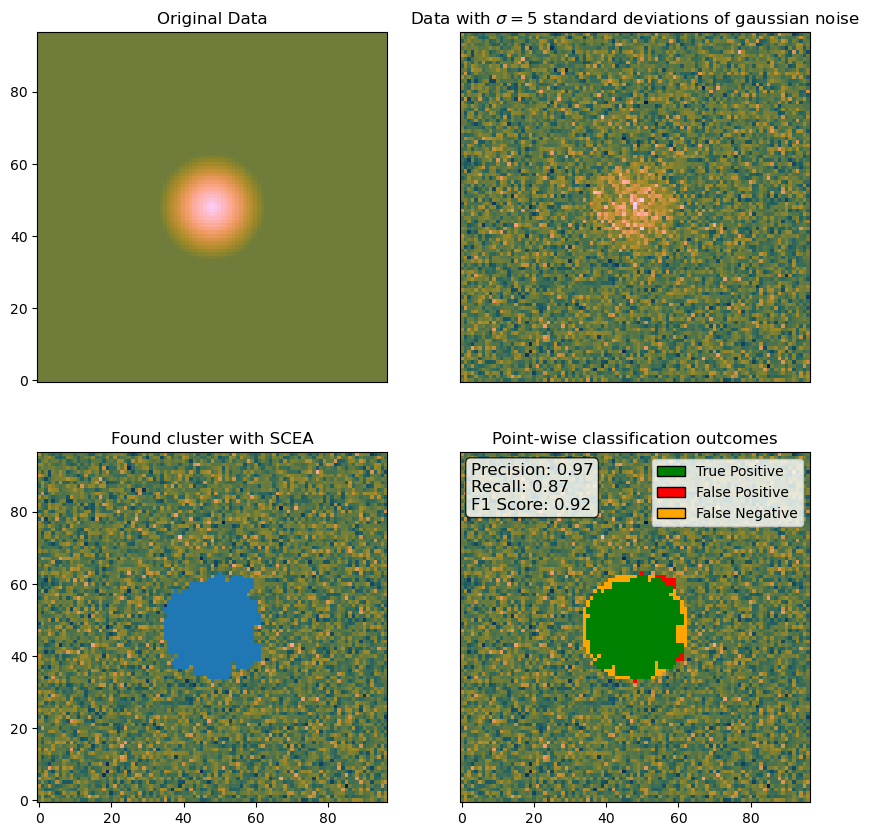

In [54]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar

noise_sigma = 3
radius_func_sigmas_threshold = 0.6

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)


plot_clusters_imshow_2(
    points,
    values,
    values_noisy,
    clusters,
    labels,
    s=50,
    vmin=values_noisy.min(),
    vmax=values_noisy.max(),
    save_to=None
)

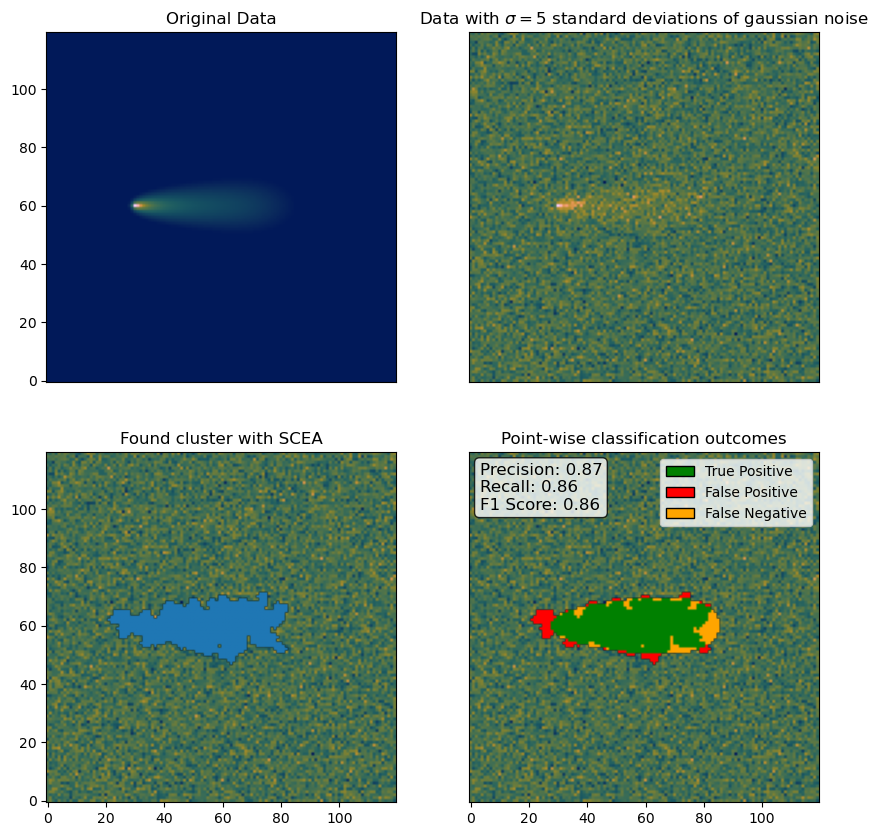

In [55]:
# Example

values = values_advection
points = points_advection
labels = labels_advection

noise_sigma = 5
radius_func_sigmas_threshold = 0.5

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters=1,
    point_value_threshold="stds_from_median",
    stds=3.5,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=0,
    verbose=False,
)

save_to = plots_path / "advectiondiffusion_example.pdf"
plot_clusters_imshow_2(
    points,
    values,
    values_noisy,
    clusters,
    labels,
    s=50,
    save_to = save_to,
    vmin=None,
    vmax=None,
)



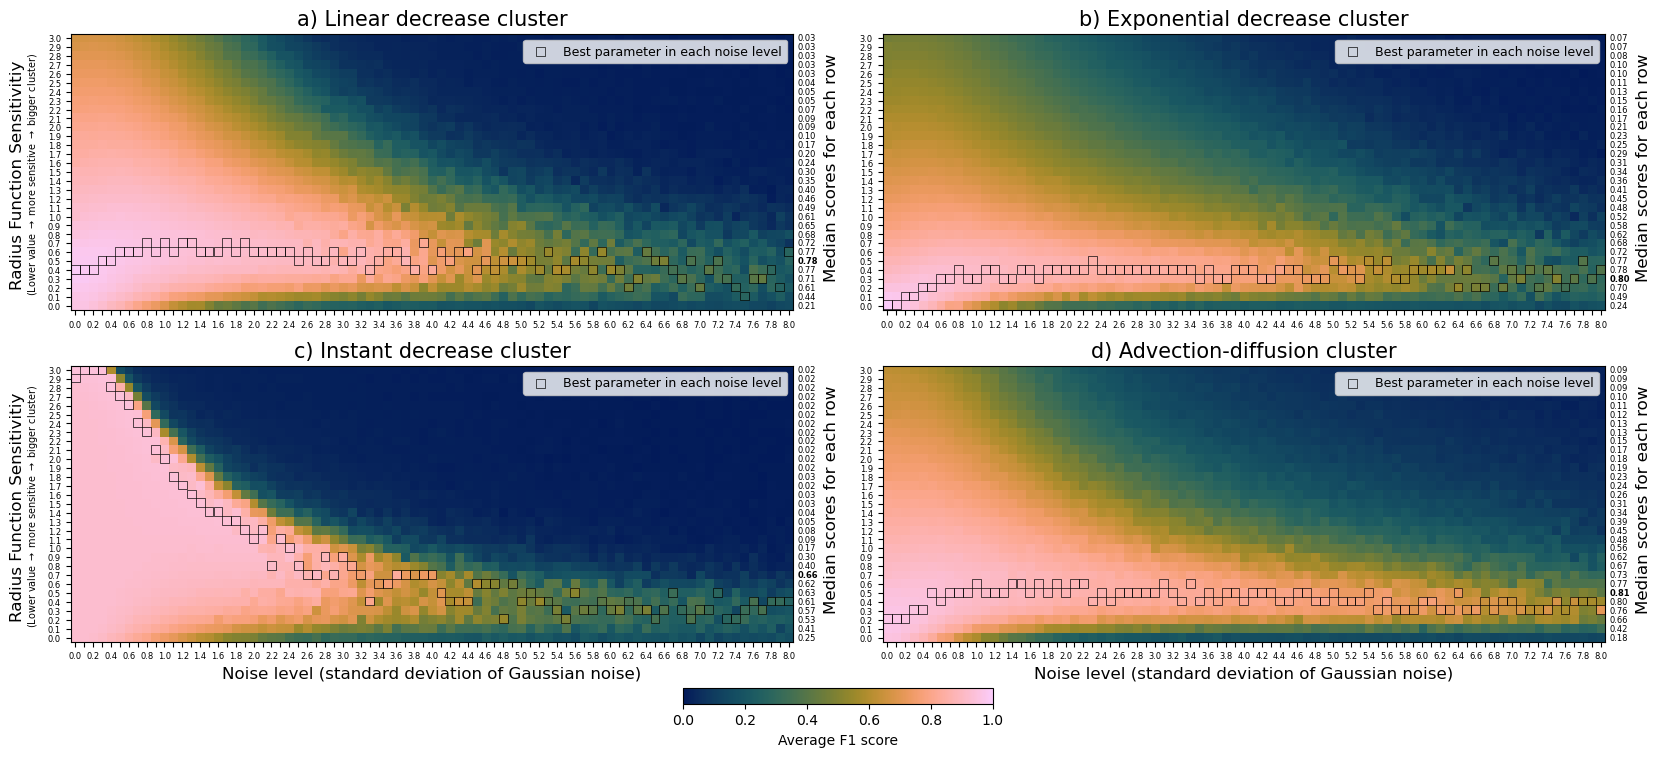

In [192]:

title="Heatmap of F1 Scores Across Different Noise Levels and Radius Function Sensitivity parameters"
y_label="Radius Function Sensitivitiy \n"
best_param_box_size=41
save_to=None
save_to=plots_path/"combined_heatmap.pdf"

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()

### First plot

scores_per_radius_func_s = []
filename = [
    "scores_per_radiusfuncs_noise_linearpolar_25-02-28_18-26.npy",
    "scores_per_radiusfuncs_noise_exponentialpolar_25-02-28_23-58.npy",
    "scores_per_radiusfuncs_noise_cylinder_25-03-01_05-40.npy",
    "scores_per_radiusfuncs_noise_advectiondiffusion_25-03-01_20-59.npy",
]
title = [
    "a) Linear decrease cluster",
    "b) Exponential decrease cluster",
    "c) Instant decrease cluster",
    "d) Advection-diffusion cluster",
]
y_label='Radius Function Sensitivitiy \n'

for i in range(4):
    scores_per_radius_func_s = np.load(outputs_path / filename[i])
    scores_per_radius_func_s = np.array(scores_per_radius_func_s)
    cax = ax[i].matshow(scores_per_radius_func_s, vmin=0, vmax=1,origin='lower')

    # Set ticks for every point
    xticks = np.arange(len(noise_levels))
    yticks = np.arange(len(radius_func_sigmas_thresholds))

    ax[i].set_xticks(xticks)
    ax[i].set_yticks(yticks)

    # Set labels for every other tick
    ax[i].set_xticklabels(
        [
            str(label) if i % 2 == 0 else ""
            for i, label in enumerate(noise_levels.round(4))
        ],
    )
    ax[i].set_yticklabels(
        [
            str(label) if i % 1 == 0 else ""
            for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
        ]
    )
    ax[i].xaxis.tick_bottom()             # Moves ticks to the bottom
    ax[i].xaxis.set_label_position('bottom')  # Sets the x-label to the bottom

    # Lower the font size of the tick labels and rotate them
    ax[i].tick_params(axis="both", which="major", labelsize=6)
    plt.setp(ax[i].get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax[i].get_yticklabels(), rotation=0, ha="right")
    # Put the median scores for each parameter in the second y axis labels on the right of the heatmap
    # median_scores_per_parameter = scores_per_radius_func_s.median(axis=1)
    median_scores_per_parameter = np.median(scores_per_radius_func_s, axis=1)
    # Add text annotations for median scores
    max_median_score = median_scores_per_parameter.max()
    for j, median_score in enumerate(median_scores_per_parameter):
        if median_score == max_median_score:
            ax[i].text(
                len(noise_levels),
                j,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=6,
                fontweight="bold",
            )
        else:
            ax[i].text(
                len(noise_levels),
                j,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=6,
            )
    # Add a title on the right for the median values
    ax[i].text(
        len(noise_levels) + 3.0,
        len(radius_func_sigmas_thresholds) / 2,
        "Median scores for each row",
        va="center",
        rotation=90,
        ha="left",
        fontsize=12,
    )
    ax[i].scatter(
        np.arange(len(scores_per_radius_func_s[0])),
        np.argmax(scores_per_radius_func_s, axis=0) + 0.1,
        marker="s",
        linewidths=0.6,
        edgecolor="black",
        alpha=0.8,
        s=best_param_box_size,
        facecolor="none",
        label=f"Best parameter in each noise level",
    )
    ax[i].legend(fontsize=9)

    if i in [2, 3]: 
        ax[i].set_xlabel("Noise level (standard deviation of Gaussian noise)", fontsize=12)
    if i in [0, 2]:
        ax[i].set_ylabel(y_label, fontsize=12)
    if i in [0, 2]:
        ax[i].text(
            - 5.5,
            len(radius_func_sigmas_thresholds) / 2 -0.7,
            f"(Lower value $\\rightarrow$ more sensitive $\\rightarrow$ bigger cluster)",
            va="center",
            rotation=90,
            ha="left",
            fontsize=7,
        )
    #ax[i].set_ylabel("Radius_func_sigma -parameter\n$\\small{(lower\\ value\\ \\rightarrow\\ more\\ sensitive)}$")
    ax[i].set_title(title[i], fontsize=15,)


plt.subplots_adjust(
    #left=0.1, 
    #right=0.9, 
    #top=0.9, 
    #bottom=0.1,
    wspace=0.1, 
    #hspace=0.2
    )

# Add a common colorbar to the right
cbar = fig.colorbar(cax, ax=ax.ravel().tolist(), shrink=0.2, pad=0.06, orientation="horizontal")
cbar.set_label("Average F1 score")


if save_to:
    plt.savefig(save_to, bbox_inches="tight", transparent=True, format="pdf")

plt.show()

In [208]:
scores_per_radius_func_s = np.load(outputs_path / "scores_per_radiusfuncs_noise_advectiondiffusion_25-03-01_20-59.npy")
scores_per_radius_func_s = np.array(scores_per_radius_func_s)
print(scores_per_radius_func_s.shape)

scores_per_radius_func_s[:,50]


(31, 81)


array([0.167746  , 0.39318515, 0.62139697, 0.73479409, 0.76417554,
       0.77171776, 0.70905984, 0.60572027, 0.54251593, 0.49124757,
       0.43183669, 0.3642932 , 0.3399598 , 0.26737789, 0.22383707,
       0.20258427, 0.1733371 , 0.16608642, 0.16430944, 0.15084108,
       0.10759203, 0.11575593, 0.10573335, 0.09099452, 0.09259239,
       0.07335647, 0.0785492 , 0.07007854, 0.06387522, 0.05649442,
       0.04765199])

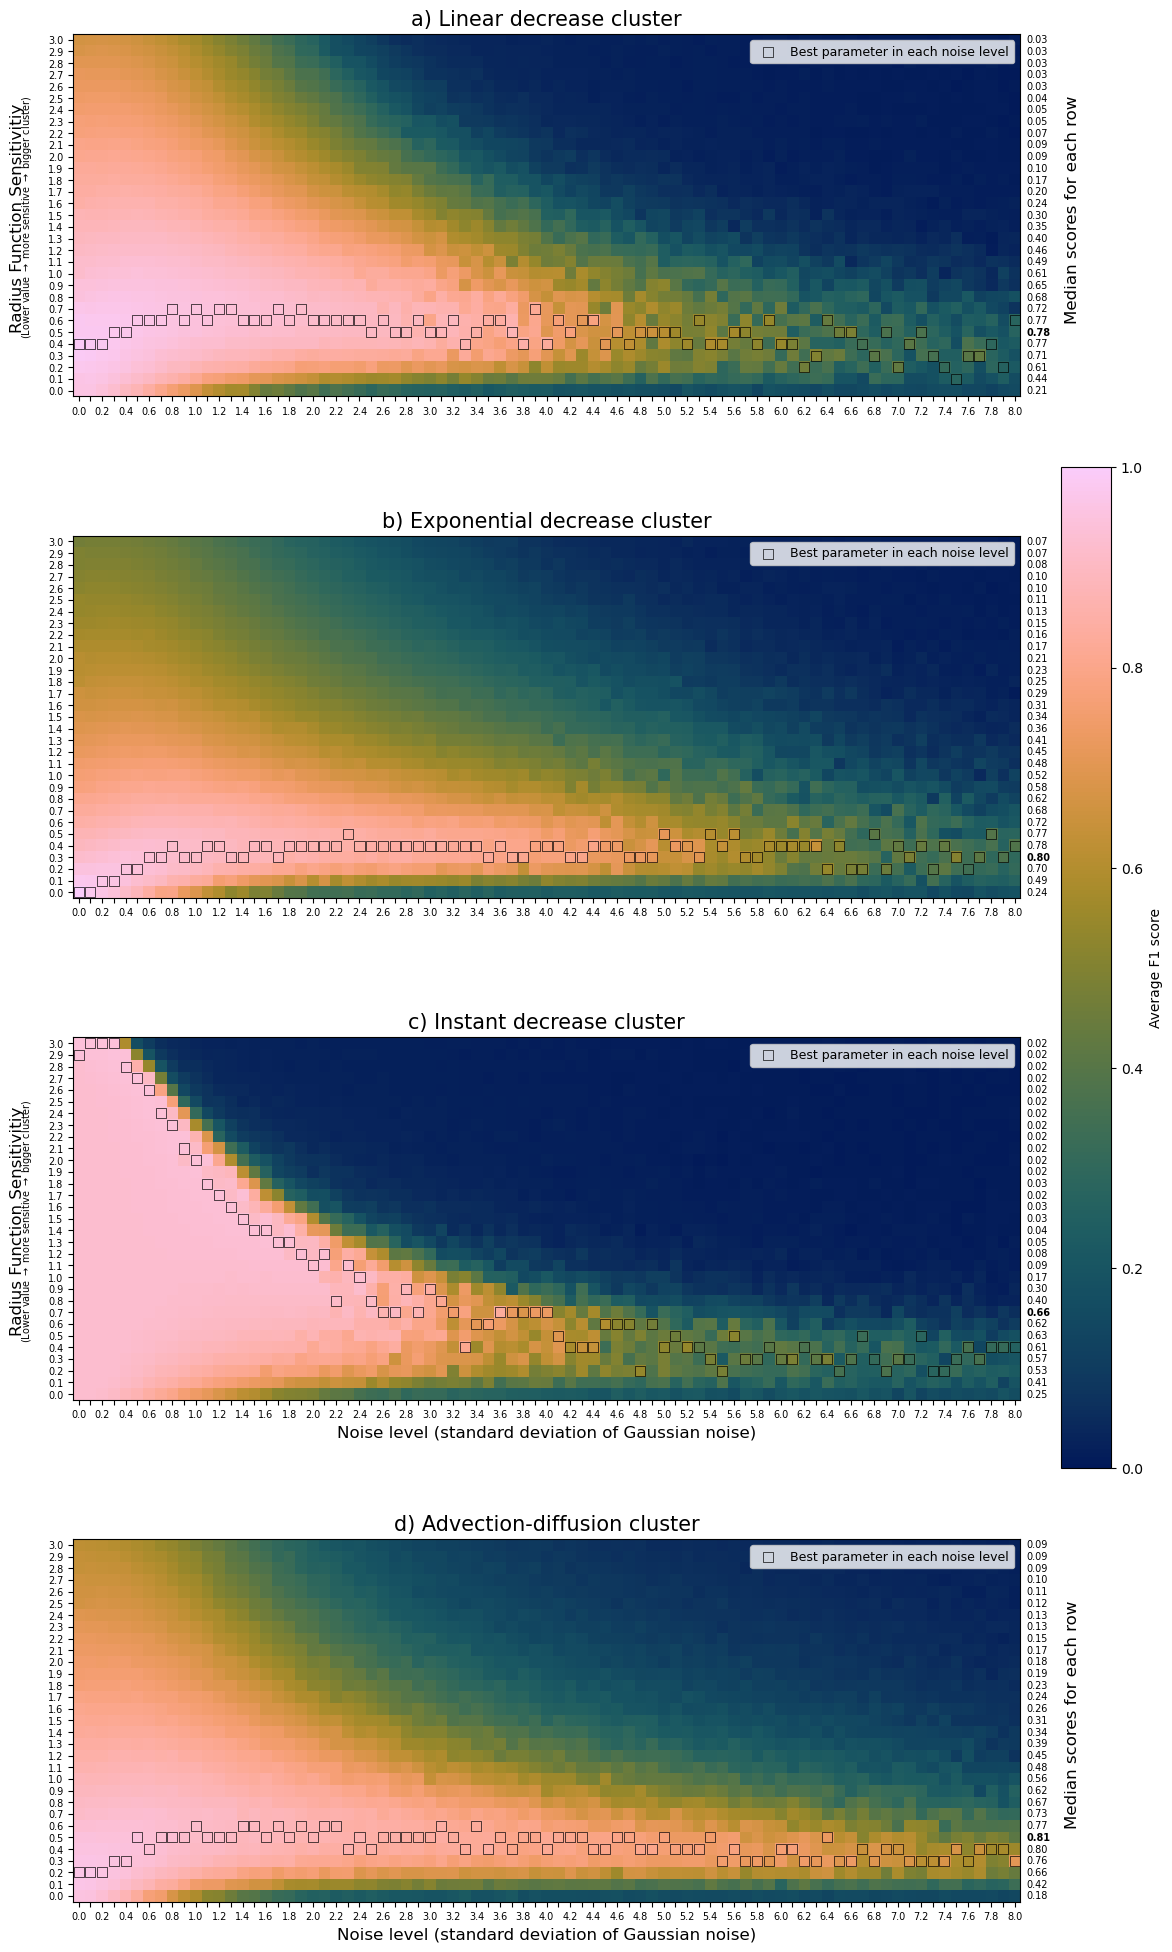

In [96]:

title="Heatmap of F1 Scores Across Different Noise Levels and Radius Function Sensitivity parameters"
y_label="Radius Function Sensitivitiy \n"
best_param_box_size=52
save_to=None
#save_to=plots_path/"combined_heatmap.pdf"

noise_levels = np.arange(0, 8.1, 0.1)  # Standard deviations of the noise
radius_func_sigmas_thresholds = np.arange(0, 3.1, 0.1)

fig, ax = plt.subplots(4, 1, figsize=(15, 26))
ax = ax.flatten()

### First plot

scores_per_radius_func_s = []
filename = [
    "scores_per_radiusfuncs_noise_linearpolar_25-02-28_18-26.npy",
    "scores_per_radiusfuncs_noise_exponentialpolar_25-02-28_23-58.npy",
    "scores_per_radiusfuncs_noise_cylinder_25-03-01_05-40.npy",
    "scores_per_radiusfuncs_noise_advectiondiffusion_25-03-01_20-59.npy",
]
title = [
    "a) Linear decrease cluster",
    "b) Exponential decrease cluster",
    "c) Instant decrease cluster",
    "d) Advection-diffusion cluster",
]
y_label='Radius Function Sensitivitiy \n'

for i in range(4):
    scores_per_radius_func_s = np.load(outputs_path / filename[i])
    scores_per_radius_func_s = np.array(scores_per_radius_func_s)
    cax = ax[i].matshow(scores_per_radius_func_s, vmin=0, vmax=1,origin='lower')

    # Set ticks for every point
    xticks = np.arange(len(noise_levels))
    yticks = np.arange(len(radius_func_sigmas_thresholds))

    ax[i].set_xticks(xticks)
    ax[i].set_yticks(yticks)

    # Set labels for every other tick
    ax[i].set_xticklabels(
        [
            str(label) if i % 2 == 0 else ""
            for i, label in enumerate(noise_levels.round(4))
        ],
    )
    ax[i].set_yticklabels(
        [
            str(label) if i % 1 == 0 else ""
            for i, label in enumerate(radius_func_sigmas_thresholds.round(4))
        ]
    )
    ax[i].xaxis.tick_bottom()             # Moves ticks to the bottom
    ax[i].xaxis.set_label_position('bottom')  # Sets the x-label to the bottom

    # Lower the font size of the tick labels and rotate them
    ax[i].tick_params(axis="both", which="major", labelsize=7)
    plt.setp(ax[i].get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax[i].get_yticklabels(), rotation=0, ha="right")
    # Put the median scores for each parameter in the second y axis labels on the right of the heatmap
    # median_scores_per_parameter = scores_per_radius_func_s.median(axis=1)
    median_scores_per_parameter = np.median(scores_per_radius_func_s, axis=1)
    # Add text annotations for median scores
    max_median_score = median_scores_per_parameter.max()
    for j, median_score in enumerate(median_scores_per_parameter):
        if median_score == max_median_score:
            ax[i].text(
                len(noise_levels),
                j,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=7,
                fontweight="bold",
            )
        else:
            ax[i].text(
                len(noise_levels),
                j,
                f"{median_score:.2f}",
                va="center",
                ha="left",
                fontsize=7,
            )
    # Add a title on the right for the median values
    ax[i].text(
        len(noise_levels) + 3.3,
        len(radius_func_sigmas_thresholds) / 2,
        "Median scores for each row",
        va="center",
        rotation=90,
        ha="left",
        fontsize=12,
    )
    ax[i].scatter(
        np.arange(len(scores_per_radius_func_s[0])),
        np.argmax(scores_per_radius_func_s, axis=0),
        marker="s",
        linewidths=0.6,
        edgecolor="black",
        alpha=0.8,
        s=best_param_box_size,
        facecolor="none",
        label=f"Best parameter in each noise level",
    )
    ax[i].legend(fontsize=9)

    if i in [2, 3]: 
        ax[i].set_xlabel("Noise level (standard deviation of Gaussian noise)", fontsize=12)
    if i in [0, 2]:
        ax[i].set_ylabel(y_label, fontsize=12)
    if i in [0, 2]:
        ax[i].text(
            - 5,
            len(radius_func_sigmas_thresholds) / 2 -0.7,
            f"(Lower value $\\rightarrow$ more sensitive $\\rightarrow$ bigger cluster)",
            va="center",
            rotation=90,
            ha="left",
            fontsize=7,
        )
    #ax[i].set_ylabel("Radius_func_sigma -parameter\n$\\small{(lower\\ value\\ \\rightarrow\\ more\\ sensitive)}$")
    ax[i].set_title(title[i], fontsize=15,)


plt.subplots_adjust(
    #left=0.1, 
    #right=0.9, 
    #top=0.9, 
    #bottom=0.1,
    wspace=0.12, 
    hspace=0.01
    )

# Add a common colorbar to the right
cbar = fig.colorbar(cax, ax=ax.ravel().tolist(), shrink=0.5, pad=0.035)
cbar.set_label("Average F1 score")


if save_to:
    plt.savefig(save_to, bbox_inches="tight", transparent=True, format="pdf")

plt.show()

## Data - multicluster

### Linear polar

In [45]:
linear_function_polar = lambda r: np.maximum(-r * 4 + 16, 1)

meshgrid = np.meshgrid(
    np.linspace(-12, 12, 96, endpoint=False), np.linspace(-12, 12, 96, endpoint=False)
)
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()

# Convert Cartesian coordinates to polar coordinates
R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

values = linear_function_polar(R)

points_linear_polar_2 = np.array([x + 24, y]).T
x_linear_polar_2 = x + 24
y_linear_polar_2 = y
meshgrid_linear_polar_2 = meshgrid
values_linear_polar_2 = values
labels_linear_polar_2 = values > 1

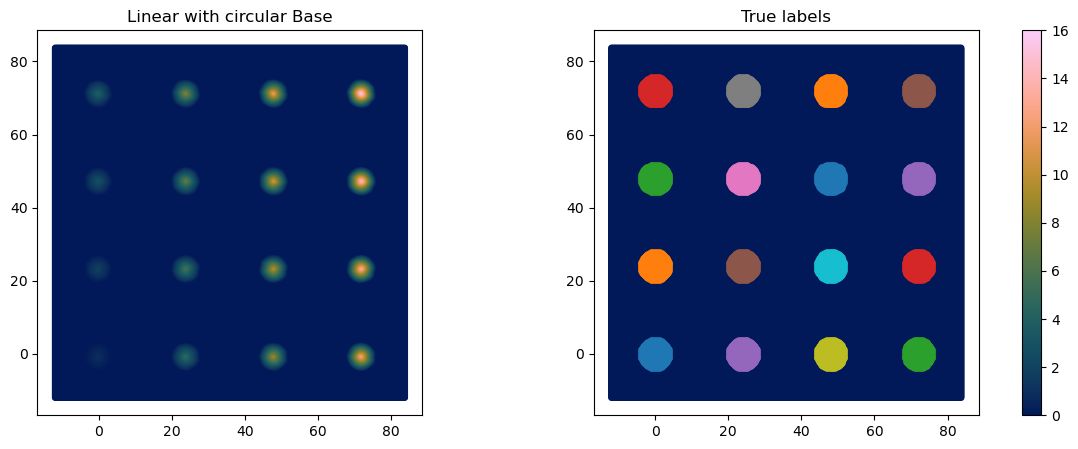

In [88]:
# linear_function_polar = lambda r: np.maximum(-r*4 + 16, 1)

X = []
Y = []
VALUES = []
LABELS = []
POINTS = []

k = 0
for i in range(4):
    for j in range(4):

        k = k + 1
        divide_by = 16 / k
        linear_function_polar = lambda r: np.maximum((-r * 4 + 16) / divide_by, 0)

        meshgrid = np.meshgrid(
            np.linspace(-12, 12, 96, endpoint=False),
            np.linspace(-12, 12, 96, endpoint=False),
        )
        x = meshgrid[0].flatten()
        y = meshgrid[1].flatten()

        # Convert Cartesian coordinates to polar coordinates
        R = np.sqrt(x**2 + y**2)  # How far the grid point is from the origin

        values = linear_function_polar(R)

        x_linear_polar = x + 24 * i
        y_linear_polar = y + 24 * j
        points_linear_polar = np.array([x_linear_polar, y_linear_polar]).T
        meshgrid_linear_polar = meshgrid
        values_linear_polar = values
        labels_linear_polar = (values > 0) * k

        X.append(x_linear_polar)
        Y.append(y_linear_polar)
        VALUES.append(values_linear_polar)
        LABELS.append(labels_linear_polar)
        POINTS.append(points_linear_polar)

x_linear_polar = np.concatenate(X)
y_linear_polar = np.concatenate(Y)
values_linear_polar = np.concatenate(VALUES)
labels_linear_polar = np.concatenate(LABELS)
points_linear_polar = np.concatenate(POINTS)

# With polar coordinates, so that the base is circular

x = x_linear_polar
y = y_linear_polar
values = values_linear_polar
labels = labels_linear_polar


# Plot the function
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flatten()

# 1st plot
sc = axs[0].scatter(x.flatten(), y.flatten(), c=values.flatten(), s=12)
axs[0].set_title("Linear with circular Base")
axs[0].set_aspect("equal")

# 2nd plot
axs[1].scatter(x, y, c=values, s=12)
for i in range(1, k + 1):
    axs[1].scatter(x[labels == i], y[labels == i], s=12)
axs[1].set_title("True labels")
axs[1].set_aspect("equal")

## 3rd plot
# axs[2].plot(x[np.where(y == 0)], linear_function_polar(R[np.where(y == 0)]))
# axs[2].set_title("Side profile")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)

# Save as pdf
save_to = plots_path / "linear_multicluster.png"
plt.savefig(save_to, bbox_inches="tight", transparent=True, format="png")

plt.show()

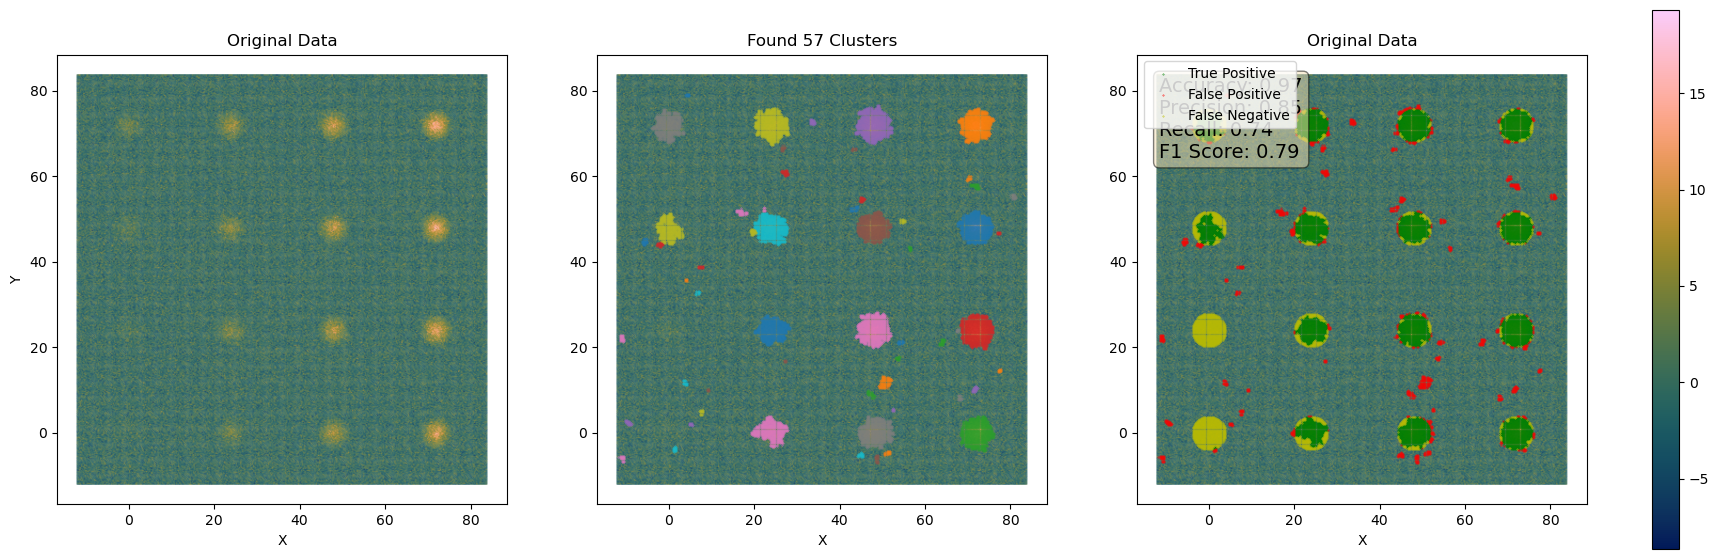

In [98]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar

noise_sigma = 2
radius_func_sigmas_threshold = 0.6

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters="auto",
    point_value_threshold="stds_from_median",
    stds=3,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=24,
    verbose=False,
)


plot_clusters(points, values_noisy, clusters, labels, s=0.1, 
              save_to=plots_path / "linear_multicluster_example.png", save_format="png")

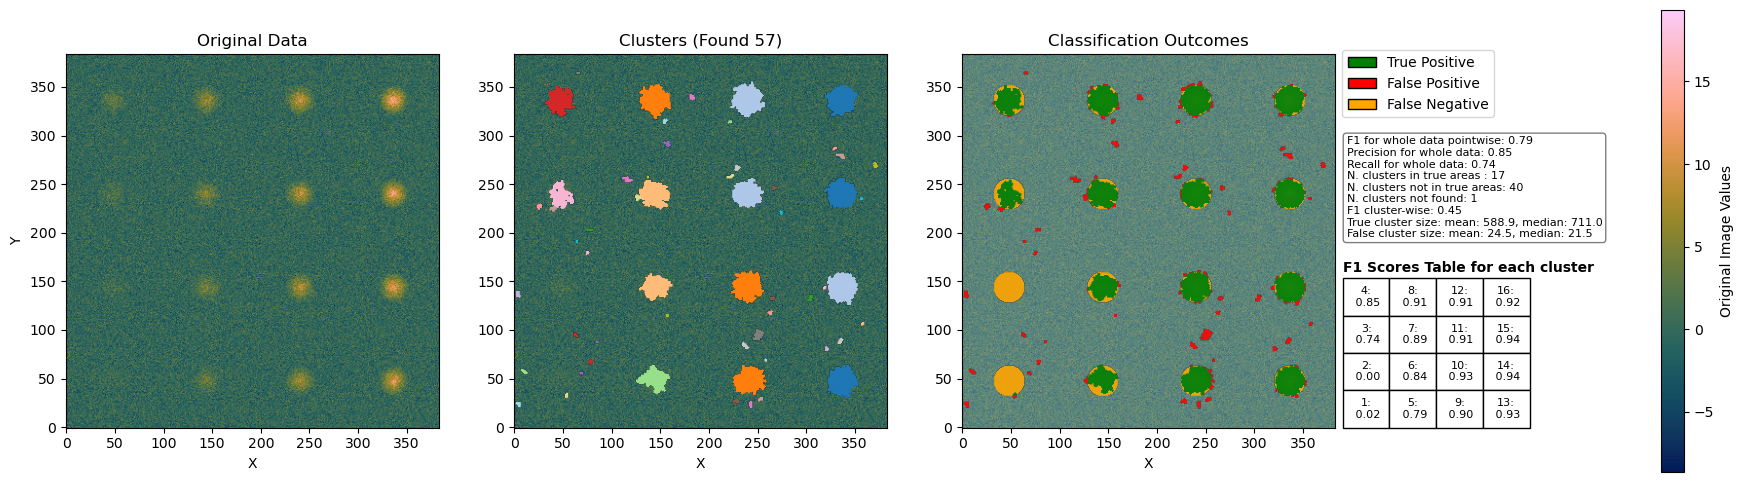

In [99]:
plot_clusters_multicluster(points, values_noisy, clusters, labels, save_to=plots_path / "linear_multicluster_example.png", save_format="png")

## Experiment multicluster

- Label every found cluster as False, True uniquely, True non-uniquely
- Label each true cluster as how well it was found, and how many different clusters where in the area, under how many other clusters were it on top of

<br>

- How to measure success? What metrics to use?
    - For every true cluster, the F-score without taking into account how many different clusters were found there.
    - OR take the largest found cluster there?
    - OR penalize if there is more clusters found that one

- asdf

### Little bit of testing

In [ ]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar

noise_sigma = 4
radius_func_sigmas_threshold = 0.6
stds = 4

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters="auto",
    point_value_threshold="stds_from_median",
    stds=stds,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=24,
    verbose=False,
)


plot_clusters_multicluster(points, values_noisy, clusters, labels)

In [ ]:
plot_clusters_multicluster(points, values_noisy, clusters, labels, s=0.05)

In [ ]:
# For every true cluster, calculate the f-score
# Take every unique found cluster in the true cluster and check how well they match

# Initialize a list to store the f1 scores for each true cluster
f1_scores = []

# Iterate over each true cluster
for true_label in np.unique(labels):
    if true_label == 0:
        continue  # Skip the background label

    found_clusters_in_true_cluster = np.unique(clusters[labels == true_label])
    # Skip the background label (label 0)
    found_clusters_in_true_cluster = found_clusters_in_true_cluster[
        found_clusters_in_true_cluster != 0
    ]

    is_cluster = np.isin(clusters, found_clusters_in_true_cluster)

    tp, fp, tn, fn = classification_outcomes(
        clusters=is_cluster, labels=(labels == true_label), reutrn_counts=True
    )
    f1 = 2 * tp / (2 * tp + fp + fn)
    f1_scores.append(f1)
    print(
        f"True cluster {true_label}: F1 score = {f1:.2f}. Found clusters: {found_clusters_in_true_cluster.shape[0]}, {found_clusters_in_true_cluster}."
    )

In [ ]:
# See how many of the found clusters are in a true cluster

unique_found_clusters = np.unique(clusters[clusters > 0])

true_found_clusters = np.unique(clusters[(labels > 0) & (clusters > 0)])
true_found_clusters

false_found_clusters = unique_found_clusters[
    ~np.isin(unique_found_clusters, true_found_clusters)
]

n_true_positive_clusters = true_found_clusters.shape[0]
n_false_postive_clusters = false_found_clusters.shape[0]
n_unique_found_clusters = unique_found_clusters.shape[0]


print(
    f"True found clusters: {n_true_positive_clusters}, False found clusters: {n_false_postive_clusters}, Percentage of True found clusters: {n_true_positive_clusters/n_unique_found_clusters:.2%}"
)

# Average and median size of each true found cluster
true_found_clusters_sizes = []
for true_found_cluster in true_found_clusters:
    true_found_clusters_sizes.append(np.sum(clusters == true_found_cluster))
mean_true_found_clusters_size = np.mean(true_found_clusters_sizes)
median_true_found_clusters_size = np.median(true_found_clusters_sizes)
print(f"Average size of each true found cluster: {mean_true_found_clusters_size:.2f}")
print(f"Median size of each true found cluster: {median_true_found_clusters_size:.2f}")

# Average and median size of each false found cluster
false_found_clusters_sizes = []
for false_found_cluster in false_found_clusters:
    false_found_clusters_sizes.append(np.sum(clusters == false_found_cluster))
mean_false_found_clusters_size = np.mean(false_found_clusters_sizes)
median_false_found_clusters_size = np.median(false_found_clusters_sizes)
print(f"Average size of each false found cluster: {mean_false_found_clusters_size:.2f}")
print(
    f"Median size of each false found cluster: {median_false_found_clusters_size:.2f}"
)

In [ ]:
# Of all found cluster points, how many are in a true cluster in general

tp, fp, tn, fn = classification_outcomes(clusters > 0, labels > 0, reutrn_counts=True)
f1 = 2 * tp / (2 * tp + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"F1 score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

In [ ]:
(
    f1_general,
    precision_general,
    recall_general,
    f1_scores,
    n_unique_found_clusters_in_true_cluster,
    n_true_positive_clusters,
    n_false_postive_clusters,
    mean_true_found_clusters_size,
    median_true_found_clusters_size,
    mean_false_found_clusters_size,
    median_false_found_clusters_size,
) = calculate_metrics_for_multiclusters(clusters, labels, verbose=True)


### Linear 

In [ ]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar
filename = (
    "asdftestitesti"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

radius_func_sigmas_threshold = 0.5

noise_levels = np.arange(0, 9.1, 0.5)  # Standard deviations of the noise
n_repetitions_per_noise_level = 5
stds = np.arange(2.5, 5.1, 0.5)


# Initialize lists
f1_general_list = []
precision_general_list = []
recall_general_list = []
f1_scores_list = []
n_unique_found_clusters_in_true_cluster_list = []
n_true_positive_clusters_list = []
n_false_positive_clusters_list = []
mean_true_found_clusters_size_list = []
median_true_found_clusters_size_list = []
mean_false_found_clusters_size_list = []
median_false_found_clusters_size_list = []


# First standardize data set
values_standardized = (values - values.mean()) / values.std()

for k, std in enumerate(tqdm(stds)):

    f1_general_averages = [0] * len(noise_levels)
    precision_general_averages = [0] * len(noise_levels)
    recall_general_averages = [0] * len(noise_levels)
    f1_scores_averages = [0] * len(noise_levels)
    n_unique_found_clusters_in_true_cluster_averages = [0] * len(noise_levels)
    n_true_positive_clusters_averages = [0] * len(noise_levels)
    n_false_positive_clusters_averages = [0] * len(noise_levels)
    mean_true_found_clusters_size_averages = [0] * len(noise_levels)
    median_true_found_clusters_size_averages = [0] * len(noise_levels)
    mean_false_found_clusters_size_averages = [0] * len(noise_levels)
    median_false_found_clusters_size_averages = [0] * len(noise_levels)
    
    
    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_general_individual_runs = [0] * n_repetitions_per_noise_level
        precision_general_individual_runs = [0] * n_repetitions_per_noise_level
        recall_general_individual_runs = [0] * n_repetitions_per_noise_level
        f1_scores_individual_runs = [0] * n_repetitions_per_noise_level
        n_unique_found_clusters_in_true_cluster_individual_runs = [0] * n_repetitions_per_noise_level
        n_true_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        n_false_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        mean_true_found_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_true_found_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        mean_false_found_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_false_found_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level


        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            
            # add noise
            values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters="auto",
                point_value_threshold="stds_from_median",
                stds=std,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_sigmas_threshold,
                max_points_in_start_radius=6,
                local_box_size=24,
                verbose=False,
            )

            pass
            # calculate metrics
            (
                f1_general,
                precision_general,
                recall_general,
                f1_scores,
                n_unique_found_clusters_in_true_cluster,
                n_true_positive_clusters,
                n_false_postive_clusters,
                mean_true_found_clusters_size,
                median_true_found_clusters_size,
                mean_false_found_clusters_size,
                median_false_found_clusters_size,
            ) = calculate_metrics_for_multiclusters(clusters, labels, verbose=False)

            pass

            f1_general_individual_runs[j] = f1_general
            precision_general_individual_runs[j] = precision_general
            recall_general_individual_runs[j] = recall_general
            f1_scores_individual_runs[j] = f1_scores
            n_unique_found_clusters_in_true_cluster_individual_runs[j] = n_unique_found_clusters_in_true_cluster
            n_true_positive_clusters_individual_runs[j] = n_true_positive_clusters
            n_false_positive_clusters_individual_runs[j] = n_false_postive_clusters
            mean_true_found_clusters_size_individual_runs[j] = mean_true_found_clusters_size
            median_true_found_clusters_size_individual_runs[j] = median_true_found_clusters_size
            mean_false_found_clusters_size_individual_runs[j] = mean_false_found_clusters_size
            median_false_found_clusters_size_individual_runs[j] = median_false_found_clusters_size

        # Average over the repetitions
        f1_general_averages[i] = np.mean(f1_general_individual_runs)
        precision_general_averages[i] = np.mean(precision_general_individual_runs)
        recall_general_averages[i] = np.mean(recall_general_individual_runs)
        f1_scores_averages[i] = np.mean(f1_scores_individual_runs, axis=0)
        n_unique_found_clusters_in_true_cluster_averages[i] = np.mean(n_unique_found_clusters_in_true_cluster_individual_runs)
        n_true_positive_clusters_averages[i] = np.mean(n_true_positive_clusters_individual_runs)
        n_false_positive_clusters_averages[i] = np.mean(n_false_positive_clusters_individual_runs)
        mean_true_found_clusters_size_averages[i] = np.mean(mean_true_found_clusters_size_individual_runs)
        median_true_found_clusters_size_averages[i] = np.mean(median_true_found_clusters_size_individual_runs)
        mean_false_found_clusters_size_averages[i] = np.mean(mean_false_found_clusters_size_individual_runs)
        median_false_found_clusters_size_averages[i] = np.mean(median_false_found_clusters_size_individual_runs)


    # Append the averages to the lists
    f1_general_list.append(f1_general_averages)
    precision_general_list.append(precision_general_averages)
    recall_general_list.append(recall_general_averages)
    f1_scores_list.append(f1_scores_averages)
    n_unique_found_clusters_in_true_cluster_list.append(n_unique_found_clusters_in_true_cluster_averages)
    n_true_positive_clusters_list.append(n_true_positive_clusters_averages)
    n_false_positive_clusters_list.append(n_false_positive_clusters_averages)
    mean_true_found_clusters_size_list.append(mean_true_found_clusters_size_averages)
    median_true_found_clusters_size_list.append(median_true_found_clusters_size_averages)
    mean_false_found_clusters_size_list.append(mean_false_found_clusters_size_averages)
    median_false_found_clusters_size_list.append(median_false_found_clusters_size_averages)

    
all_in_one_list = [
    f1_general_list,
    precision_general_list,
    recall_general_list,
    f1_scores_list,
    n_unique_found_clusters_in_true_cluster_list,
    n_true_positive_clusters_list,
    n_false_positive_clusters_list,
    mean_true_found_clusters_size_list,
    median_true_found_clusters_size_list,
    mean_false_found_clusters_size_list,
    median_false_found_clusters_size_list,
]


np.save(outputs_path / filename, np.array(all_in_one_list, dtype=object))
#129min

In [ ]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar
filename = (
    "scores_per_stds_noise_linear"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

radius_func_sigmas_threshold = 0.5
noise_levels = np.arange(0, 8.1, 0.2)  # Standard deviations of the noise
n_repetitions_per_noise_level = 3
stds = np.arange(3, 5.1, 0.1)


# Initialize lists
f1_general_list = []
precision_general_list = []
recall_general_list = []
f1_scores_list = []
n_unique_found_clusters_in_true_cluster_list = []
n_true_positive_clusters_list = []
n_false_positive_clusters_list = []
n_false_negative_clusters_individual_runs = []
f1_scores_whole_clusters_list = []
mean_true_positive_clusters_size_list = []
median_true_positive_clusters_size_list = []
mean_false_positive_clusters_size_list = []
median_false_positive_clusters_size_list = []


# First standardize data set
values_standardized = (values - values.mean()) / values.std()

for k, std in enumerate(tqdm(stds)):

    f1_general_averages = [0] * len(noise_levels)
    precision_general_averages = [0] * len(noise_levels)
    recall_general_averages = [0] * len(noise_levels)
    f1_scores_averages = [0] * len(noise_levels)
    n_unique_found_clusters_in_true_cluster_averages = [0] * len(noise_levels)
    n_true_positive_clusters_averages = [0] * len(noise_levels)
    n_false_positive_clusters_averages = [0] * len(noise_levels)
    n_false_negative_clusters_averages = [0] * len(noise_levels)
    f1_scores_whole_clusters_averages = [0] * len(noise_levels)
    mean_true_positive_clusters_size_averages = [0] * len(noise_levels)
    median_true_positive_clusters_size_averages = [0] * len(noise_levels)
    mean_false_positive_clusters_size_averages = [0] * len(noise_levels)
    median_false_positive_clusters_size_averages = [0] * len(noise_levels)
    
    
    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_general_individual_runs = [0] * n_repetitions_per_noise_level
        precision_general_individual_runs = [0] * n_repetitions_per_noise_level
        recall_general_individual_runs = [0] * n_repetitions_per_noise_level
        f1_scores_individual_runs = [0] * n_repetitions_per_noise_level
        n_unique_found_clusters_in_true_cluster_individual_runs = [0] * n_repetitions_per_noise_level
        n_true_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        n_false_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        n_false_negative_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        f1_scores_whole_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        mean_true_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_true_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        mean_false_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_false_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level


        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            
            # add noise
            values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters="auto",
                point_value_threshold="stds_from_median",
                stds=std,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_sigmas_threshold,
                max_points_in_start_radius=6,
                local_box_size=24,
                verbose=False,
            )

            
            # calculate metrics
            (
                f1_general,
                precision_general,
                recall_general,
                f1_scores,
                n_unique_found_clusters_in_true_cluster,
                n_true_positive_clusters,
                n_false_postive_clusters,
                n_false_negative_clusters,
                f1_scores_whole_clusters,
                mean_true_positive_clusters_size,
                median_true_positive_clusters_size,
                mean_false_positive_clusters_size,
                median_false_positive_clusters_size,
            ) = calculate_metrics_for_multiclusters(clusters, labels, verbose=False)

            

            f1_general_individual_runs[j] = f1_general
            precision_general_individual_runs[j] = precision_general
            recall_general_individual_runs[j] = recall_general
            f1_scores_individual_runs[j] = f1_scores
            n_unique_found_clusters_in_true_cluster_individual_runs[j] = n_unique_found_clusters_in_true_cluster
            n_true_positive_clusters_individual_runs[j] = n_true_positive_clusters
            n_false_positive_clusters_individual_runs[j] = n_false_postive_clusters
            n_false_negative_clusters_individual_runs[j] = n_false_negative_clusters
            f1_scores_whole_clusters_individual_runs[j] = f1_scores_whole_clusters
            mean_true_positive_clusters_size_individual_runs[j] = mean_true_positive_clusters_size
            median_true_positive_clusters_size_individual_runs[j] = median_true_positive_clusters_size
            mean_false_positive_clusters_size_individual_runs[j] = mean_false_positive_clusters_size
            median_false_positive_clusters_size_individual_runs[j] = median_false_positive_clusters_size

        # Average over the repetitions
        f1_general_averages[i] = np.mean(f1_general_individual_runs)
        precision_general_averages[i] = np.mean(precision_general_individual_runs)
        recall_general_averages[i] = np.mean(recall_general_individual_runs)
        f1_scores_averages[i] = np.mean(f1_scores_individual_runs, axis=0)
        n_unique_found_clusters_in_true_cluster_averages[i] = np.mean(n_unique_found_clusters_in_true_cluster_individual_runs)
        n_true_positive_clusters_averages[i] = np.mean(n_true_positive_clusters_individual_runs)
        n_false_positive_clusters_averages[i] = np.mean(n_false_positive_clusters_individual_runs)
        n_false_negative_clusters_averages[i] = np.mean(n_false_negative_clusters_individual_runs)
        f1_scores_whole_clusters_averages[i] = np.mean(f1_scores_whole_clusters_individual_runs)
        mean_true_positive_clusters_size_averages[i] = np.mean(mean_true_positive_clusters_size_individual_runs)
        median_true_positive_clusters_size_averages[i] = np.mean(median_true_positive_clusters_size_individual_runs)
        mean_false_positive_clusters_size_averages[i] = np.mean(mean_false_positive_clusters_size_individual_runs)
        median_false_positive_clusters_size_averages[i] = np.mean(median_false_positive_clusters_size_individual_runs)


    # Append the averages to the lists
    f1_general_list.append(np.array(f1_general_averages))
    precision_general_list.append(np.array(precision_general_averages))
    recall_general_list.append(np.array(recall_general_averages))
    f1_scores_list.append(np.array(f1_scores_averages))
    n_unique_found_clusters_in_true_cluster_list.append(np.array(n_unique_found_clusters_in_true_cluster_averages))
    n_true_positive_clusters_list.append(np.array(n_true_positive_clusters_averages))
    n_false_positive_clusters_list.append(np.array(n_false_positive_clusters_averages))
    n_false_negative_clusters_individual_runs.append(np.array(n_false_negative_clusters_individual_runs))
    f1_scores_whole_clusters_list.append(np.array(f1_scores_whole_clusters_averages))
    mean_true_positive_clusters_size_list.append(np.array(mean_true_positive_clusters_size_averages))
    median_true_positive_clusters_size_list.append(np.array(median_true_positive_clusters_size_averages))
    mean_false_positive_clusters_size_list.append(np.array(mean_false_positive_clusters_size_averages))
    median_false_positive_clusters_size_list.append(np.array(median_false_positive_clusters_size_averages))

    
all_in_one_list = [
    f1_general_list,
    precision_general_list,
    recall_general_list,
    f1_scores_list,
    n_unique_found_clusters_in_true_cluster_list,
    n_true_positive_clusters_list,
    n_false_positive_clusters_list,
    n_false_negative_clusters_individual_runs,
    f1_scores_whole_clusters_list,
    mean_true_positive_clusters_size_list,
    median_true_positive_clusters_size_list,
    mean_false_positive_clusters_size_list,
    median_false_positive_clusters_size_list,
]


np.save(outputs_path / filename, np.array(all_in_one_list, dtype=object))

In [115]:
all_in_one_list = np.load(outputs_path / "scores_per_stds_noise_linear25-03-05_08-44.npy", allow_pickle=True)
noise_levels = np.arange(0, 8.1, 0.2)  # Standard deviations of the noise
stds = np.arange(3, 5.1, 0.1)


In [116]:
# TODO make this work for all.

# Define a recursive flattening function
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, (list, tuple, np.ndarray)):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

# Suppose this is your three-dimensional nested list
nested_list = all_in_one_list[0]

# Get the flattened list
flat = flatten(nested_list)

# Determine the target shape. For our example, it's (2, 2, 2)
target_shape = (
    len(nested_list), 
    len(np.array(nested_list[0],dtype=float)), 
    #len(np.array(nested_list[0][0],dtype=float))
)

# Convert the flat list to a NumPy float array and reshape it
f1_scores_list = np.array(flat, dtype=float).reshape(target_shape)

f1_scores_list.shape


(21, 41)

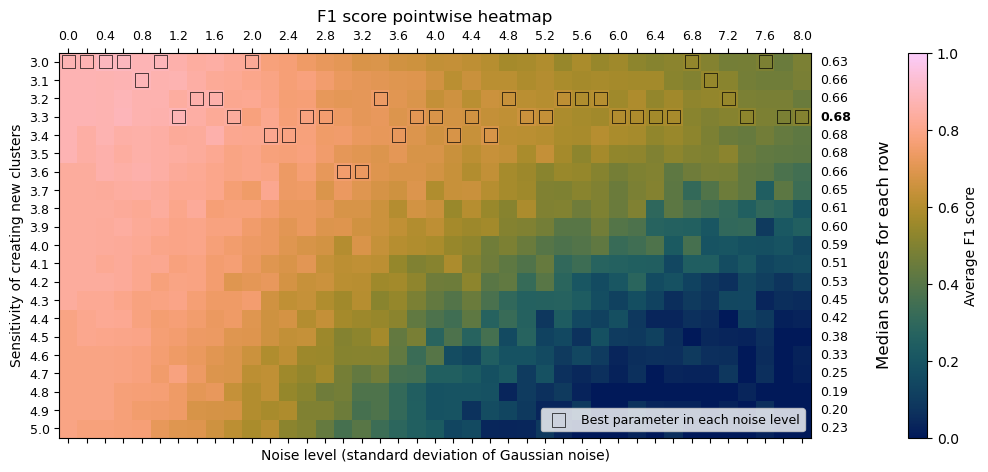

In [117]:
# F1 score pointwise heatmap

plot_heatmap(
    f1_scores_list,
    noise_levels,
    stds,
    y_label="Sensitivity of creating new clusters",
    title="F1 score pointwise heatmap",
    save_to=None
    #filename=plots_path / "heatmap_f1_general.png",
)

In [118]:
# TODO make this work for all.

# Define a recursive flattening function
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, (list, tuple, np.ndarray)):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

# Suppose this is your three-dimensional nested list
nested_list = all_in_one_list[8]

# Get the flattened list
flat = flatten(nested_list)

# Determine the target shape. For our example, it's (2, 2, 2)
target_shape = (
    len(nested_list), 
    len(np.array(nested_list[0],dtype=float)), 
    #len(np.array(nested_list[0][0],dtype=float))
)

# Convert the flat list to a NumPy float array and reshape it
f1_scores_list = np.array(flat, dtype=float).reshape(target_shape)

f1_scores_list.shape


(21, 41)

In [119]:
stds

array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
       4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

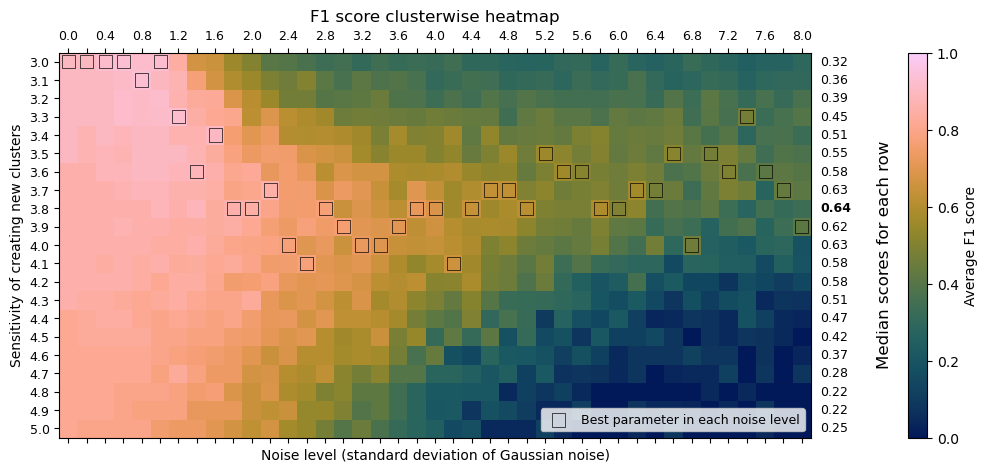

In [120]:
# Clusterwise

plot_heatmap(
    f1_scores_list,
    noise_levels,
    stds,
    y_label="Sensitivity of creating new clusters",
    title="F1 score clusterwise heatmap",
    save_to=plots_path / "heatmap_f1_multicluster_linear.pdf",
)

In [121]:
# Define a recursive flattening function
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, (list, tuple, np.ndarray)):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

# Suppose this is your three-dimensional nested list
nested_list = all_in_one_list[3]

# Get the flattened list
flat = flatten(nested_list)

# Determine the target shape. For our example, it's (2, 2, 2)
target_shape = (
    len(nested_list), 
    len(np.array(nested_list[0],dtype=float)), 
    len(np.array(nested_list[0][0],dtype=float))
)

# Convert the flat list to a NumPy float array and reshape it
f1_scores_list = np.array(flat, dtype=float).reshape(target_shape)

f1_scores_list.shape

f1_scores_for_each_individual_cluster = f1_scores_list

In [122]:
f1_scores_for_each_individual_cluster[:,:,15]

array([[0.97677419, 0.97853717, 0.9799405 , 0.97375148, 0.97297497,
        0.96651232, 0.95692915, 0.95775083, 0.94796611, 0.93637608,
        0.93576364, 0.94226544, 0.91945887, 0.93578085, 0.91765333,
        0.90434472, 0.90534643, 0.89359857, 0.8677032 , 0.92416962,
        0.89585604, 0.90367696, 0.91854625, 0.87672735, 0.8769085 ,
        0.87351889, 0.86931433, 0.88815645, 0.87832196, 0.86885671,
        0.86752252, 0.88481454, 0.86260138, 0.85372234, 0.85150473,
        0.84830453, 0.8325865 , 0.8907845 , 0.83803298, 0.81464402,
        0.82692639],
       [0.97677419, 0.97546247, 0.97533499, 0.97321848, 0.96473779,
        0.96678797, 0.96374289, 0.95241063, 0.94650513, 0.94116245,
        0.94344065, 0.92355729, 0.93859088, 0.92754341, 0.92984981,
        0.92574402, 0.91503408, 0.92412861, 0.90122774, 0.9129006 ,
        0.91348724, 0.89633896, 0.91149597, 0.88492734, 0.89713633,
        0.88289593, 0.9033527 , 0.86106657, 0.87313819, 0.86964948,
        0.87315349, 0.87814

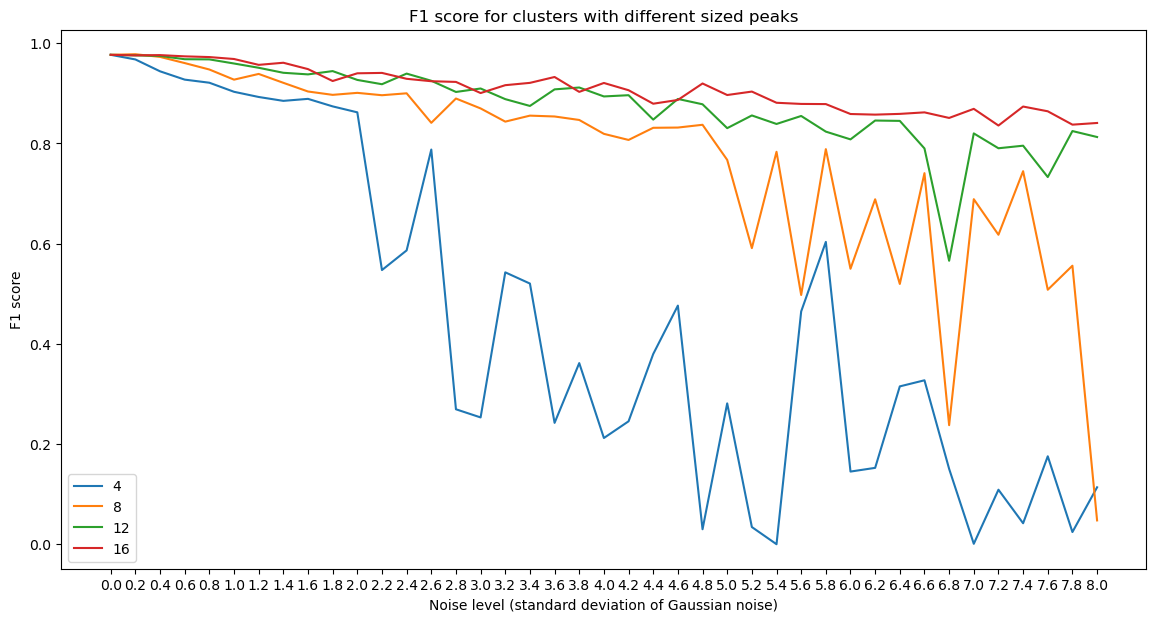

In [136]:
plt.figure(figsize=(14, 7))

# The dimensions are: stds, noise_levels, individual clusters
for i in range(3,16,4):   
    plt.plot(f1_scores_list[2,:,i], label=f"{i+1}")


plt.xticks(
    np.arange(len(noise_levels)), 
    [str(label) for label in noise_levels.round(2)]
)

plt.xlabel("Noise level (standard deviation of Gaussian noise)")
plt.ylabel("F1 score")

plt.title("F1 score for clusters with different sized peaks")

plt.legend()

### Exponential

In [ ]:
# Example

values = values_linear_polar
points = points_linear_polar
labels = labels_linear_polar

noise_sigma = 8
radius_func_sigmas_threshold = 0.6
stds = 3

# First standardize data set
values_standardized = (values - values.mean()) / values.std()

# add noise
values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

# cluster
clusters = SCEA.scea(
    points,
    values_noisy,
    radius_func="default",
    n_clusters="auto",
    point_value_threshold="stds_from_median",
    stds=stds,
    distance_matrix="euclidean",
    radius_func_sigmas_threshold=radius_func_sigmas_threshold,
    max_points_in_start_radius=6,
    local_box_size=24,
    verbose=False,
)


plot_clusters_multicluster(points, values_noisy, clusters, labels)

In [ ]:
# Example

values = values_exponential_polar
points = points_exponential_polar
labels = labels_exponential_polar
filename = (
    "asdftestitestiii"
    + datetime.datetime.now().strftime("%y-%m-%d_%H-%M")
    + ".npy"
)

radius_func_sigmas_threshold = 0.5

noise_levels = np.arange(0, 3.1, 0.5)  # Standard deviations of the noise
n_repetitions_per_noise_level = 2
stds = np.arange(2.5, 4.1, 0.5)


# Initialize lists
f1_general_list = []
precision_general_list = []
recall_general_list = []
f1_scores_list = []
n_unique_found_clusters_in_true_cluster_list = []
n_true_positive_clusters_list = []
n_false_positive_clusters_list = []
n_false_negative_clusters_individual_runs = []
f1_scores_whole_clusters_list = []
mean_true_positive_clusters_size_list = []
median_true_positive_clusters_size_list = []
mean_false_positive_clusters_size_list = []
median_false_positive_clusters_size_list = []


# First standardize data set
values_standardized = (values - values.mean()) / values.std()

for k, std in enumerate(tqdm(stds)):

    f1_general_averages = [0] * len(noise_levels)
    precision_general_averages = [0] * len(noise_levels)
    recall_general_averages = [0] * len(noise_levels)
    f1_scores_averages = [0] * len(noise_levels)
    n_unique_found_clusters_in_true_cluster_averages = [0] * len(noise_levels)
    n_true_positive_clusters_averages = [0] * len(noise_levels)
    n_false_positive_clusters_averages = [0] * len(noise_levels)
    n_false_negative_clusters_averages = [0] * len(noise_levels)
    f1_scores_whole_clusters_averages = [0] * len(noise_levels)
    mean_true_positive_clusters_size_averages = [0] * len(noise_levels)
    median_true_positive_clusters_size_averages = [0] * len(noise_levels)
    mean_false_positive_clusters_size_averages = [0] * len(noise_levels)
    median_false_positive_clusters_size_averages = [0] * len(noise_levels)
    
    
    # Iterate over noise levels
    for i, noise_sigma in enumerate(noise_levels):

        f1_general_individual_runs = [0] * n_repetitions_per_noise_level
        precision_general_individual_runs = [0] * n_repetitions_per_noise_level
        recall_general_individual_runs = [0] * n_repetitions_per_noise_level
        f1_scores_individual_runs = [0] * n_repetitions_per_noise_level
        n_unique_found_clusters_in_true_cluster_individual_runs = [0] * n_repetitions_per_noise_level
        n_true_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        n_false_positive_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        n_false_negative_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        f1_scores_whole_clusters_individual_runs = [0] * n_repetitions_per_noise_level
        mean_true_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_true_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        mean_false_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level
        median_false_positive_clusters_size_individual_runs = [0] * n_repetitions_per_noise_level


        # Repeat the experiment multiple times
        for j in range(n_repetitions_per_noise_level):
            
            # add noise
            values_noisy = values_standardized + np.random.normal(0, noise_sigma, values.shape)

            # cluster
            clusters = SCEA.scea(
                points,
                values_noisy,
                radius_func="default",
                n_clusters="auto",
                point_value_threshold="stds_from_median",
                stds=std,
                distance_matrix="euclidean",
                radius_func_sigmas_threshold=radius_func_sigmas_threshold,
                max_points_in_start_radius=6,
                local_box_size=24,
                verbose=False,
            )

            
            # calculate metrics
            (
                f1_general,
                precision_general,
                recall_general,
                f1_scores,
                n_unique_found_clusters_in_true_cluster,
                n_true_positive_clusters,
                n_false_postive_clusters,
                n_false_negative_clusters,
                f1_scores_whole_clusters,
                mean_true_positive_clusters_size,
                median_true_positive_clusters_size,
                mean_false_positive_clusters_size,
                median_false_positive_clusters_size,
            ) = calculate_metrics_for_multiclusters(clusters, labels, verbose=False)

            

            f1_general_individual_runs[j] = f1_general
            precision_general_individual_runs[j] = precision_general
            recall_general_individual_runs[j] = recall_general
            f1_scores_individual_runs[j] = f1_scores
            n_unique_found_clusters_in_true_cluster_individual_runs[j] = n_unique_found_clusters_in_true_cluster
            n_true_positive_clusters_individual_runs[j] = n_true_positive_clusters
            n_false_positive_clusters_individual_runs[j] = n_false_postive_clusters
            n_false_negative_clusters_individual_runs[j] = n_false_negative_clusters
            f1_scores_whole_clusters_individual_runs[j] = f1_scores_whole_clusters
            mean_true_positive_clusters_size_individual_runs[j] = mean_true_positive_clusters_size
            median_true_positive_clusters_size_individual_runs[j] = median_true_positive_clusters_size
            mean_false_positive_clusters_size_individual_runs[j] = mean_false_positive_clusters_size
            median_false_positive_clusters_size_individual_runs[j] = median_false_positive_clusters_size

        # Average over the repetitions
        f1_general_averages[i] = np.mean(f1_general_individual_runs)
        precision_general_averages[i] = np.mean(precision_general_individual_runs)
        recall_general_averages[i] = np.mean(recall_general_individual_runs)
        f1_scores_averages[i] = np.mean(f1_scores_individual_runs, axis=0)
        n_unique_found_clusters_in_true_cluster_averages[i] = np.mean(n_unique_found_clusters_in_true_cluster_individual_runs)
        n_true_positive_clusters_averages[i] = np.mean(n_true_positive_clusters_individual_runs)
        n_false_positive_clusters_averages[i] = np.mean(n_false_positive_clusters_individual_runs)
        n_false_negative_clusters_averages[i] = np.mean(n_false_negative_clusters_individual_runs)
        f1_scores_whole_clusters_averages[i] = np.mean(f1_scores_whole_clusters_individual_runs)
        mean_true_positive_clusters_size_averages[i] = np.mean(mean_true_positive_clusters_size_individual_runs)
        median_true_positive_clusters_size_averages[i] = np.mean(median_true_positive_clusters_size_individual_runs)
        mean_false_positive_clusters_size_averages[i] = np.mean(mean_false_positive_clusters_size_individual_runs)
        median_false_positive_clusters_size_averages[i] = np.mean(median_false_positive_clusters_size_individual_runs)


    # Append the averages to the lists
    f1_general_list.append(f1_general_averages)
    precision_general_list.append(precision_general_averages)
    recall_general_list.append(recall_general_averages)
    f1_scores_list.append(f1_scores_averages)
    n_unique_found_clusters_in_true_cluster_list.append(n_unique_found_clusters_in_true_cluster_averages)
    n_true_positive_clusters_list.append(n_true_positive_clusters_averages)
    n_false_positive_clusters_list.append(n_false_positive_clusters_averages)
    n_false_negative_clusters_individual_runs.append(n_false_negative_clusters_individual_runs)
    f1_scores_whole_clusters_list.append(f1_scores_whole_clusters_averages)
    mean_true_positive_clusters_size_list.append(mean_true_positive_clusters_size_averages)
    median_true_positive_clusters_size_list.append(median_true_positive_clusters_size_averages)
    mean_false_positive_clusters_size_list.append(mean_false_positive_clusters_size_averages)
    median_false_positive_clusters_size_list.append(median_false_positive_clusters_size_averages)

    
all_in_one_list = [
    f1_general_list,
    precision_general_list,
    recall_general_list,
    f1_scores_list,
    n_unique_found_clusters_in_true_cluster_list,
    n_true_positive_clusters_list,
    n_false_positive_clusters_list,
    n_false_negative_clusters_individual_runs,
    f1_scores_whole_clusters_list,
    mean_true_positive_clusters_size_list,
    median_true_positive_clusters_size_list,
    mean_false_positive_clusters_size_list,
    median_false_positive_clusters_size_list,
]


np.save(outputs_path / filename, np.array(all_in_one_list, dtype=object))

In [ ]:
radius_func_sigmas_threshold = 0.5

noise_levels = np.arange(0, 3.1, 0.2)  # Standard deviations of the noise
n_repetitions_per_noise_level = 3
stds = np.arange(2.5, 4.1, 0.2)


all_in_one_list = np.load(outputs_path / "asdftestitestiii25-03-04_17-18.npy", allow_pickle=True)

f1_general = all_in_one_list[0]

plot_heatmap(
    np.array(f1_general, dtype=float),
    noise_levels,
    stds,
    #filename=plots_path / "heatmap_f1_general.png",
)

In [ ]:
all_in_one_list